# Figure 3 : Free atmosphere and near-surface warming as a function of elevation
Use the phd_v3 environment (can be replicated from the .yml file in envs/)

In [1]:
import xarray as xr
#import rioxarray as rxr
import xesmf as xe
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter
import string


from pyproj import CRS,Transformer,Proj

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
                 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
big_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
              'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50],'lonlim':[0.,20.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2,
                    'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}


### Defining the Alps

In [37]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False


#### Defining the elevation bands and pressure levels

In [38]:
def p_to_z(P):
    p0 = 1013.25 # hPa
    gamma = 6.5*10**(-3) # K/m
    T0 = 288.5 # K
    g = 9.81 # m.s^-2
    R = 287 # J/kg/K
    altitude = T0/gamma*(1-(P/p0)**(gamma*R/g))
    return altitude

# To get the equivalence between pressure level and elevation, uncomment after having run the rest of the notebook

# for press in slopes_ECEarth_hist.plev.values[:10]:
#     print(p_to_z(press/100))

In [5]:
# Levels (altitude bands)

levels = [np.logical_and(alps,H<400), np.logical_and(alps,np.logical_and(H>=400,H<600)), np.logical_and(alps,np.logical_and(H>=600,H<800)),
          np.logical_and(alps,np.logical_and(H>=800,H<1000)), np.logical_and(alps,np.logical_and(H>=1000,H<1200)), np.logical_and(alps,np.logical_and(H>=1200,H<1400)),
          np.logical_and(alps,np.logical_and(H>=1400,H<1600)), np.logical_and(alps,np.logical_and(H>=1600,H<1800)), np.logical_and(alps,np.logical_and(H>=1800,H<2000)),
          np.logical_and(alps,np.logical_and(H>=2000,H<2200)), np.logical_and(alps,np.logical_and(H>=2200,H<2400)), np.logical_and(alps,np.logical_and(H>=2400,H<2600)),
          np.logical_and(alps,np.logical_and(H>=2600,H<2800)), np.logical_and(alps,np.logical_and(H>=2800,H<3000)),
          np.logical_and(alps,H>=3000)]#,
          #alps]


H_levels = [300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900,3100]
H_levels_pressure = [760,1460,1950,3015,4210,5580,11785]
H_levels_pressure314 = [1460,3015,4210,5580,11785]
H_levels_pressure_GCM = [110, 760,1460,3015,4210,5580,7190,9170,10370,11785] # 1000, 925, 850.,  700.,  600.,  500.,  400., 300.,  250.,  200.

### Functions

In [1]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [39]:
def altitude_lev_slopes(dataset_slopes,levels,Height_levels=H_levels):
    ds_slopes_Hlev = dataset_slopes.where(levels[0]).mean(dim=('x','y'))
    ds_slopes_Hlev_std = dataset_slopes.where(levels[0]).std(dim=('x','y'))

    for lev in range(1,len(levels)):
        ds_slopes_Hlev = xr.concat([ds_slopes_Hlev,dataset_slopes.where(levels[lev]).mean(dim=('x','y'))], dim='Hlev')
        ds_slopes_Hlev_std = xr.concat([ds_slopes_Hlev_std,dataset_slopes.where(levels[lev]).std(dim=('x','y'))], dim='Hlev')

    ds_slopes_Hlev = ds_slopes_Hlev.assign_coords(Hlev=("Hlev", Height_levels))
    ds_slopes_Hlev_std = ds_slopes_Hlev_std.assign_coords(Hlev=("Hlev", Height_levels))

    return ds_slopes_Hlev.sel(degree=1), ds_slopes_Hlev_std.sel(degree=1)

In [8]:
def make_ds_seas(path,simcode,vars,first_year,last_year):

    # creating seasonal dataarray with all vars
    Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
    t_timestep = 60*60*24 # 60*60*24 seconds in a day

    ds_yrs = xr.open_dataset(path+'.EU'+simcode+'.'+vars[0]+'.'+str(first_year)+'.nc')#.resample(time='D').mean()

    for var in vars[1:]:
        ds_var = xr.open_dataset(path+'.EU'+simcode+'.'+var+'.'+str(first_year)+'.nc')#.resample(time='D').mean()
        ds_yrs[var] = ds_var[var]


    ds_yrs = season_mean(ds_yrs).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

    for year in range(first_year+1,last_year+1):
        print(year,end=' ')
        ds_singleyr = xr.open_dataset(path+'.EU'+simcode+'.'+vars[0]+'.'+str(year)+'.nc')#.resample(time='D').mean()

        for var in vars[1:]:
            ds_var = xr.open_dataset(path+'.EU'+simcode+'.'+var+'.'+str(year)+'.nc')#.resample(time='D').mean()
            ds_singleyr[var] = ds_var[var]
    
        print('Computing season mean',end=' ')
        ds_singleyr = season_mean(ds_singleyr).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
        ds_yrs = xr.concat([ds_yrs,ds_singleyr], dim='Year')

    yrs = np.arange(first_year,last_year+1)
    ds_yrs = ds_yrs.assign_coords(Year=("Year", yrs))

    return ds_yrs
    

In [9]:
def making_slopes_gd_freeatm(ds_hist, ds_fut):
    msk_TTp = np.logical_and(ds_hist.TTp.mean(axis=0) < 1000, ds_fut.TTp.mean(axis=0) < 1000) # 1000:arbitrary value, we just want to filter 10**(34) values

    alps_TTp = np.logical_and(alps,msk_TTp)
    
    ds_slopes_hist = ds_hist.polyfit('Year', deg=1)
    ds_slopes_Hlev_hist, ds_slopes_Hlev_hist_std = altitude_lev_slopes(ds_slopes_hist.TTz_polyfit_coefficients,levels=levels)
    ds_slopes_Hlev_hist_TTp = ds_slopes_hist.sel(degree=1).TTp_polyfit_coefficients.where(alps_TTp).mean(dim=('x','y'))
    ds_slopes_Hlev_hist_std_TTp = ds_slopes_hist.sel(degree=1).TTp_polyfit_coefficients.where(alps_TTp).std(dim=('x','y'))

    ds_slopes_fut = ds_fut.polyfit('Year', deg=1)
    ds_slopes_Hlev_fut, ds_slopes_Hlev_fut_std = altitude_lev_slopes(ds_slopes_fut.TTz_polyfit_coefficients,levels=levels)
    ds_slopes_Hlev_fut_TTp = ds_slopes_fut.sel(degree=1).TTp_polyfit_coefficients.where(alps_TTp).mean(dim=('x','y'))
    ds_slopes_Hlev_fut_std_TTp = ds_slopes_fut.sel(degree=1).TTp_polyfit_coefficients.where(alps_TTp).std(dim=('x','y'))

    return ds_slopes_Hlev_hist, ds_slopes_Hlev_hist_std, ds_slopes_Hlev_hist_TTp, ds_slopes_Hlev_hist_std_TTp, ds_slopes_Hlev_fut, ds_slopes_Hlev_fut_std, \
            ds_slopes_Hlev_fut_TTp, ds_slopes_Hlev_fut_std_TTp


In [40]:
def plot_ground_freeatm(ds_in_hist1,ds_in_fut1,ds_in_hist2,ds_in_fut2,ds_in_hist3,ds_in_fut3,ds_in_hist4,ds_in_fut4,multiplier=10,label_on_left='',
                           H_levels_pressure=H_levels_pressure):
    # multiplier =10 if trends per decade
    pplt.rc.update(small=12, large=12)

    H_levels_pressure314 = [1460,3015,4210,5580,11785]
    seasons=['DJF','MAM','JJA','SON']
    # mask for under-the-surface values at 800hPa and other pressures

    ds1_slopes_Hlev_hist, ds1_slopes_Hlev_hist_std, ds1_slopes_Hlev_hist_TTp, ds1_slopes_Hlev_hist_std_TTp, ds1_slopes_Hlev_fut, ds1_slopes_Hlev_fut_std, \
    ds1_slopes_Hlev_fut_TTp, ds1_slopes_Hlev_fut_std_TTp = making_slopes_gd_freeatm(ds_in_hist1, ds_in_fut1)

    ds2_slopes_Hlev_hist, ds2_slopes_Hlev_hist_std, ds2_slopes_Hlev_hist_TTp, ds2_slopes_Hlev_hist_std_TTp, ds2_slopes_Hlev_fut, ds2_slopes_Hlev_fut_std, \
    ds2_slopes_Hlev_fut_TTp, ds2_slopes_Hlev_fut_std_TTp = making_slopes_gd_freeatm(ds_in_hist2, ds_in_fut2)

    ds3_slopes_Hlev_hist, ds3_slopes_Hlev_hist_std, ds3_slopes_Hlev_hist_TTp, ds3_slopes_Hlev_hist_std_TTp, ds3_slopes_Hlev_fut, ds3_slopes_Hlev_fut_std, \
    ds3_slopes_Hlev_fut_TTp, ds3_slopes_Hlev_fut_std_TTp = making_slopes_gd_freeatm(ds_in_hist3, ds_in_fut3)

    ds4_slopes_Hlev_hist, ds4_slopes_Hlev_hist_std, ds4_slopes_Hlev_hist_TTp, ds4_slopes_Hlev_hist_std_TTp, ds4_slopes_Hlev_fut, ds4_slopes_Hlev_fut_std, \
    ds4_slopes_Hlev_fut_TTp, ds4_slopes_Hlev_fut_std_TTp = making_slopes_gd_freeatm(ds_in_hist4, ds_in_fut4)
    
    list_slopes_Hlev_hist=[[ds1_slopes_Hlev_hist,ds2_slopes_Hlev_hist,ds3_slopes_Hlev_hist,ds4_slopes_Hlev_hist],
                           [ds1_slopes_Hlev_hist_std,ds2_slopes_Hlev_hist_std,ds3_slopes_Hlev_hist_std,ds4_slopes_Hlev_hist_std]]
    list_slopes_Hlev_hist_TTp=[[ds1_slopes_Hlev_hist_TTp,ds2_slopes_Hlev_hist_TTp,ds3_slopes_Hlev_hist_TTp,ds4_slopes_Hlev_hist_TTp],
                               [ds1_slopes_Hlev_hist_std_TTp,ds2_slopes_Hlev_hist_std_TTp,ds3_slopes_Hlev_hist_std_TTp,ds4_slopes_Hlev_hist_std_TTp]]
    list_slopes_Hlev_fut=[[ds1_slopes_Hlev_fut,ds2_slopes_Hlev_fut,ds3_slopes_Hlev_fut,ds4_slopes_Hlev_fut],
                          [ds1_slopes_Hlev_fut_std,ds2_slopes_Hlev_fut_std,ds3_slopes_Hlev_fut_std,ds4_slopes_Hlev_fut_std]]
    list_slopes_Hlev_fut_TTp=[[ds1_slopes_Hlev_fut_TTp,ds2_slopes_Hlev_fut_TTp,ds3_slopes_Hlev_fut_TTp,ds4_slopes_Hlev_fut_TTp],
                              [ds1_slopes_Hlev_fut_std_TTp,ds2_slopes_Hlev_fut_std_TTp,ds3_slopes_Hlev_fut_std_TTp,ds4_slopes_Hlev_fut_std_TTp]]
    
    f, axs = pplt.subplots(ncols=4,nrows=4,axheight=1.7,axwidth=3,right=6)

    for sim in range(len(list_slopes_Hlev_hist[0])):
        for seas in range(4):
            ax = axs[seas+4*sim]
            if len(list_slopes_Hlev_hist_TTp[0][sim].isel(season=seas)) == len(H_levels_pressure):
                #print(list_slopes_Hlev_hist_TTp[0][sim].isel(season=seas).shape)
                H_levels_pressure = H_levels_pressure
            else:
                #print('else')
                #print(list_slopes_Hlev_hist_TTp[0][sim].isel(season=seas).shape)
                H_levels_pressure = H_levels_pressure314
            for m in range(len(H_levels_pressure)):
                ax.plot([-0.15,1.9],[H_levels_pressure[m],H_levels_pressure[m]],linestyle='--',c='k',linewidth=0.75,alpha=0.3)

            ax.plot(multiplier*list_slopes_Hlev_hist[0][sim].isel(ztqlev=0,season=seas),H_levels,c='sienna',linestyle='--')
            ax.plot(multiplier*list_slopes_Hlev_fut[0][sim].isel(ztqlev=0,season=seas),H_levels,c='sienna')
        
            ax.plot(multiplier*list_slopes_Hlev_hist_TTp[0][sim].isel(season=seas),H_levels_pressure,c='deepskyblue',linestyle='--')
            ax.plot(multiplier*list_slopes_Hlev_fut_TTp[0][sim].isel(season=seas),H_levels_pressure,c='deepskyblue')
            for lev in range(len(levels)): # spatial standard deviation
                var='TTz'
                slope_var = list_slopes_Hlev_hist[0][sim].isel(ztqlev=0,season=seas)[lev]
                std_var = list_slopes_Hlev_hist[1][sim].isel(ztqlev=0,season=seas)[lev] # std
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c='sienna')

                slope_var = list_slopes_Hlev_fut[0][sim].isel(ztqlev=0,season=seas)[lev]
                std_var = list_slopes_Hlev_fut[1][sim].isel(ztqlev=0,season=seas)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c='sienna')

                if lev<len(H_levels_pressure):
                    var='TTp'
                    slope_var = list_slopes_Hlev_hist_TTp[0][sim].isel(season=seas)[lev]
                    std_var = list_slopes_Hlev_hist_TTp[1][sim].isel(season=seas)[lev]
                    ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels_pressure[lev],H_levels_pressure[lev]],c='deepskyblue',
                            linestyle='--')

                    slope_var = list_slopes_Hlev_fut_TTp[0][sim].isel(season=seas)[lev]
                    std_var = list_slopes_Hlev_fut_TTp[1][sim].isel(season=seas)[lev]
                    ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels_pressure[lev],H_levels_pressure[lev]],c='deepskyblue')

            ax.set_xlim(-0.15,1.0)
            ax.set_xticks(np.arange(0.,1.,0.25))
            ax.set_ylim(200,6000)

            if seas==3:
                if len(H_levels_pressure) == 7:
                    ax.text(1.01, 650, "925", fontsize=11)
                    ax.text(1.01, 1840, "800", fontsize=11)
                ax.text(1.01, 1340, "850", fontsize=11)
                ax.text(1.01, 2880, "700", fontsize=11)
                ax.text(1.01, 4100, "600", fontsize=11)
                ax.text(1.01, 5430, "500", fontsize=11)
                #ax.text(0.61, 11650, "200", fontsize=9)
                # if seas==2:
                #     ax.text(1.08,6000,'Pressure (hPa)',rotation='vertical',fontsize=12,wrap=False)

    #f.subplots_adjust(right=0.85)
    # Add manual subplot labels (a–h, for example)
    letters = list(string.ascii_lowercase)  # ['a','b','c',...]
    labels = letters[:len(axs)]  # e.g. ['a','b','c','d'] or ['e','f','g','h']

    # You can offset starting letter manually (e.g. start at 'e')
    start_index = 0  # 0-based, so 4 = 'e'
    labels = letters[start_index:start_index+len(axs)]

    for i, ax in enumerate(axs):
        ax.text(
            0.02, 0.95, f"({labels[i]})",
            transform=ax.transAxes,
            fontsize=13,
            fontweight='bold',
            va='top', ha='left'
        )
    f.text(0.975,0.45,'Pressure (hPa)',rotation='vertical',fontsize=12)
    axs.format(collabels=['DJF','MAM','JJA', 'SON'],xlabel='T trend (°C/decade)',ylabel='Elevation (m.a.s.l.)',rowlabels=label_on_left)

### Preparing the data

In [19]:
ds_ECEarth_hist_TTz_TTp = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST',simcode='e',vars=['TTz','TTp'],
                                       first_year=1961,last_year=2014)

1962 Computing season mean 1963 Computing season mean 1964 Computing season mean 1965 Computing season mean 1966 Computing season mean 1967 Computing season mean 1968 Computing season mean 1969 Computing season mean 1970 Computing season mean 1971 Computing season mean 1972 Computing season mean 1973 Computing season mean 1974 Computing season mean 1975 Computing season mean 1976 Computing season mean 1977 Computing season mean 1978 Computing season mean 1979 Computing season mean 1980 Computing season mean 1981 Computing season mean 1982 Computing season mean 1983 Computing season mean 1984 Computing season mean 1985 Computing season mean 1986 Computing season mean 1987 Computing season mean 1988 Computing season mean 1989 Computing season mean 1990 Computing season mean 1991 Computing season mean 1992 Computing season mean 1993 Computing season mean 1994 Computing season mean 1995 Computing season mean 1996 Computing season mean 1997 Computing season mean 1998 Computing season mean 1

In [92]:
yrs = np.arange(1961,2015)

ds_ECEarth_hist_TTz_TTp = ds_ECEarth_hist_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [93]:
ds_ECEarth_hist_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_ECEarth3/ds_TTz_TTp_1961_2014_seas.npy')

In [22]:
ds_ECEarth_SSP245_TTz_TTp = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245',simcode='e',vars=['TTz','TTp'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [90]:
yrs = np.arange(2015,2101)

ds_ECEarth_SSP245_TTz_TTp = ds_ECEarth_SSP245_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [91]:
ds_ECEarth_SSP245_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_ECEarth3/ds_TTz_TTp_2015_2100_seas.npy')

In [24]:
ds_MPI_hist_TTz_TTp = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST',simcode='y',vars=['TTz','TTp'],
                                       first_year=1961,last_year=2014)

1962 Computing season mean 1963 Computing season mean 1964 Computing season mean 1965 Computing season mean 1966 Computing season mean 1967 Computing season mean 1968 Computing season mean 1969 Computing season mean 1970 Computing season mean 1971 Computing season mean 1972 Computing season mean 1973 Computing season mean 1974 Computing season mean 1975 Computing season mean 1976 Computing season mean 1977 Computing season mean 1978 Computing season mean 1979 Computing season mean 1980 Computing season mean 1981 Computing season mean 1982 Computing season mean 1983 Computing season mean 1984 Computing season mean 1985 Computing season mean 1986 Computing season mean 1987 Computing season mean 1988 Computing season mean 1989 Computing season mean 1990 Computing season mean 1991 Computing season mean 1992 Computing season mean 1993 Computing season mean 1994 Computing season mean 1995 Computing season mean 1996 Computing season mean 1997 Computing season mean 1998 Computing season mean 1

In [88]:
yrs = np.arange(1961,2015)

ds_MPI_hist_TTz_TTp = ds_MPI_hist_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [89]:
ds_MPI_hist_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds_TTz_TTp_1961_2014_seas.npy')

In [26]:
ds_MPI_SSP245_TTz_TTp = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP245/daily/ICE.MPI-ESM_SSP245',simcode='v',vars=['TTz','TTp'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [86]:
yrs = np.arange(2015,2101)

ds_MPI_SSP245_TTz_TTp = ds_MPI_SSP245_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [87]:
ds_MPI_SSP245_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds_TTz_TTp_2015_2100_SSP245_seas.npy')

In [28]:
ds_MPI_SSP585_TTz_TTp = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP585/daily/ICE.MPI-ESM_SSP585',simcode='y',vars=['TTz','TTp'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [82]:
yrs = np.arange(2015,2101)

ds_MPI_SSP585_TTz_TTp = ds_MPI_SSP585_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [85]:
ds_MPI_SSP585_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds_TTz_TTp_2015_2100_SSP585_seas.npy')

#### v3.14

In [10]:
ds314_MPI_hist_TTz_TTp = make_ds_seas(path='/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain/HIST/ICE.MPI-ESM_HIST',simcode='n',vars=['TTz','TTp'],
                                       first_year=1961,last_year=2014)

1962 Computing season mean 1963 Computing season mean 1964 Computing season mean 1965 Computing season mean 1966 Computing season mean 1967 Computing season mean 1968 Computing season mean 1969 Computing season mean 1970 Computing season mean 1971 Computing season mean 1972 Computing season mean 1973 Computing season mean 1974 Computing season mean 1975 Computing season mean 1976 Computing season mean 1977 Computing season mean 1978 Computing season mean 1979 Computing season mean 1980 Computing season mean 1981 Computing season mean 1982 Computing season mean 1983 Computing season mean 1984 Computing season mean 1985 Computing season mean 1986 Computing season mean 1987 Computing season mean 1988 Computing season mean 1989 Computing season mean 1990 Computing season mean 1991 Computing season mean 1992 Computing season mean 1993 Computing season mean 1994 Computing season mean 1995 Computing season mean 1996 Computing season mean 1997 Computing season mean 1998 Computing season mean 1

In [11]:
yrs = np.arange(1961,2015)

ds314_MPI_hist_TTz_TTp = ds314_MPI_hist_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [12]:
ds314_MPI_hist_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds314_TTz_TTp_1961_2014_seas.npy')

In [13]:
ds314_MPI_SSP585_TTz_TTp = make_ds_seas(path='/bettik/castelli/data/MAR-MPI-ESM/v3.14/bigdomain/SSP585/ICE.MPI-ESM_SSP585',simcode='n',vars=['TTz','TTp'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [14]:
yrs = np.arange(2015,2101)

ds314_MPI_SSP585_TTz_TTp = ds314_MPI_SSP585_TTz_TTp.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

In [15]:
ds314_MPI_SSP585_TTz_TTp.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds314_TTz_TTp_2015_2100_SSP585_seas.npy')

### Making the plot

#### Loading the data prepared above

In [11]:
ds_ECEarth_hist_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_ECEarth3/ds_TTz_TTp_1961_2014_seas.npy').isel(y=slice(jmin,jmax),x=slice(imin,imax))
ds_ECEarth_SSP245_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_ECEarth3/ds_TTz_TTp_2015_2100_seas.npy').isel(y=slice(jmin,jmax),x=slice(imin,imax))

In [12]:
ds_MPI_hist_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds_TTz_TTp_1961_2014_seas.npy').isel(y=slice(jmin,jmax),x=slice(imin,imax))
ds_MPI_SSP245_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds_TTz_TTp_2015_2100_SSP245_seas.npy').isel(y=slice(jmin,jmax),
                                                                                                                                        x=slice(imin,imax))
ds_MPI_SSP585_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds_TTz_TTp_2015_2100_SSP585_seas.npy').isel(y=slice(jmin,jmax),
                                                                                                                                        x=slice(imin,imax))

In [13]:
ds314_MPI_hist_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds314_TTz_TTp_1961_2014_seas.npy').isel(y=slice(jmin,jmax),
                                                                                                                                     x=slice(imin,imax))
ds314_MPI_SSP585_TTz_TTp = xr.open_dataset('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/ds314_TTz_TTp_2015_2100_SSP585_seas.npy').isel(y=slice(jmin,jmax),
                                                                                                                                              x=slice(imin,imax))

#### Plot

In [41]:
pplt.rc['figure.facecolor'] = 'white'

plot_ground_freeatm(ds_in_hist1 = ds_ECEarth_hist_TTz_TTp, ds_in_fut1 = ds_ECEarth_SSP245_TTz_TTp,
                    ds_in_hist2 = ds_MPI_hist_TTz_TTp, ds_in_fut2 = ds_MPI_SSP245_TTz_TTp,
                    ds_in_hist3 = ds_MPI_hist_TTz_TTp, ds_in_fut3 = ds_MPI_SSP585_TTz_TTp,
                    ds_in_hist4 = ds314_MPI_hist_TTz_TTp, ds_in_fut4 = ds314_MPI_SSP585_TTz_TTp,
                    label_on_left=["EC-Earth SSP2-4.5","MPI SSP2-4.5","MPI SSP5-8.5","MPI SSP5-8.5 MARv3.14"])

/tmp/ipykernel_3334984/1982002907.py:4: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=12)
/tmp/ipykernel_3334984/1982002907.py:4: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=12)


KeyboardInterrupt: 

### Bonus : P-value

In [13]:
ds_hist = ds_MPI_hist_TTz_TTp
ds_fut = ds_MPI_SSP245_TTz_TTp

msk_TTp = np.logical_and(ds_hist.TTp.mean(axis=0) < 1000, ds_fut.TTp.mean(axis=0) < 1000) # 1000:arbitrary value, we just want to filter 10**(34) values

alps_TTp = np.logical_and(alps,msk_TTp)
    
ds_slopes_hist = ds_hist.polyfit('Year', deg=1)

In [14]:
Height_levels=H_levels

ds_hist_Hlev_TTz = ds_hist.TTz.sel(ztqlev=2.0).where(levels[0]).mean(dim=('x','y'))

for lev in range(1,len(levels)):
    ds_hist_Hlev_TTz = xr.concat([ds_hist_Hlev_TTz,ds_hist.TTz.sel(ztqlev=2.0).where(levels[lev]).mean(dim=('x','y'))], dim='Hlev')

ds_hist_Hlev_TTz = ds_hist_Hlev_TTz.assign_coords(Hlev=("Hlev", Height_levels))
ds_hist_Hlev_TTz

<xarray.DataArray 'TTz' (Hlev: 15, Year: 54, season: 4)>
array([[[  2.16208547,  11.24549881,  22.3088009 ,  11.29181234],
        [  3.27052581,  11.2045465 ,  21.65165729,  11.20752358],
        [  4.88366677,  11.46483666,  22.86491468,  10.95584428],
        ...,
        [  1.35700489,  12.08353592,  22.98697016,  12.75261302],
        [  3.63989124,  10.3857852 ,  23.86782207,  12.1805846 ],
        [  5.01645485,  11.20237087,  24.17299132,  12.30944769]],

       [[  1.94346216,  10.38152786,  21.07932061,  10.19207583],
        [  2.70045293,  10.23109932,  20.39431977,  10.22913151],
        [  4.23103019,  10.66535716,  21.68368136,   9.90131325],
        ...,
        [  0.32263356,  11.0141011 ,  21.59797065,  11.86759022],
        [  3.06099247,   9.29040175,  22.81716636,  11.25037965],
        [  4.47109651,  10.48837241,  22.99349165,  11.39304668]],

       [[  1.28264571,   9.22940946,  19.7437589 ,   9.18314871],
        [  1.94843335,   8.95676367,  19.05246272,   9.23059225],
        [  3.37128309,   9.57571305,  20.36118762,   8.89680035],
        ...,
...
        ...,
        [-11.71676997,  -4.55403492,   5.63045434,  -1.13393116],
        [-10.34602309,  -5.84131794,   5.98696725,  -1.67559278],
        [ -8.22641555,  -4.32895565,   5.10454007,  -1.58605949]],

       [[-12.16655854,  -6.08970624,   3.00408358,  -4.87806918],
        [-11.32453796,  -6.6356035 ,   1.95826528,  -4.23299752],
        [ -9.75192297,  -6.10580335,   3.10532697,  -4.85084488],
        ...,
        [-13.02830047,  -5.92783596,   3.6881102 ,  -2.61352766],
        [-11.69254519,  -7.13612375,   4.36638831,  -3.10598021],
        [ -9.63479421,  -5.66298599,   3.44187694,  -3.18825467]],

       [[-13.57668866,  -7.66352183,   1.3536638 ,  -6.38326438],
        [-12.7836999 ,  -8.16134852,   0.38449504,  -5.80593323],
        [-11.12425495,  -7.58740595,   1.42445675,  -6.35912826],
        ...,
        [-14.33614629,  -7.43913539,   1.88632536,  -4.19026323],
        [-13.23751748,  -8.56976605,   2.66238361,  -4.61700939],
        [-11.05680655,  -7.16443967,   1.95184096,  -4.78414958]]])
Coordinates:
    ztqlev   float32 2.0
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * Year     (Year) int64 1961 1962 1963 1964 1965 ... 2010 2011 2012 2013 2014
  * Hlev     (Hlev) int64 300 500 700 900 1100 1300 ... 2300 2500 2700 2900 3100

In [15]:
from scipy.stats import linregress

origin_hist=np.full([4,15],np.nan)
slope_hist=np.full([4,15],np.nan)
pvalue_hist=np.full([4,15],np.nan)

for lev in range(len(H_levels)):
    for seas in range(4):
        linregress_hist = linregress(ds_hist_Hlev_TTz.Year, ds_hist_Hlev_TTz.isel(Hlev=lev,season=seas))
        origin_hist[seas][lev] = linregress_hist.intercept
        slope_hist[seas][lev] = linregress_hist.slope
        pvalue_hist[seas][lev] = linregress_hist.pvalue

slope_hist

array([[-4.71581268e-03, -4.13048005e-03, -4.35385621e-03,
        -3.78420530e-03, -4.14761808e-03, -3.84838855e-03,
        -4.02963967e-03, -4.14215440e-03, -3.70573868e-03,
        -3.27842507e-03, -2.83021245e-03, -2.17088655e-03,
        -3.02824192e-03, -3.59354106e-03, -4.49115620e-03],
       [ 3.02166302e-03,  1.41878303e-03,  7.47979292e-04,
         4.36117660e-04,  7.78748591e-04,  1.16093888e-03,
         1.68486684e-03,  1.95791978e-03,  1.48395348e-03,
         1.15417211e-03,  4.54037883e-04,  1.53187516e-05,
         1.82309091e-04,  1.48053087e-04,  5.78522627e-04],
       [ 2.41120025e-02,  2.38754382e-02,  2.39977281e-02,
         2.43350316e-02,  2.44830084e-02,  2.48840867e-02,
         2.50068406e-02,  2.50766251e-02,  2.52220741e-02,
         2.51507156e-02,  2.48670766e-02,  2.50749305e-02,
         2.33136437e-02,  2.25184485e-02,  2.09604010e-02],
       [ 1.85527375e-02,  1.96424436e-02,  2.07023607e-02,
         2.18293179e-02,  2.23520563e-02,  2.31753216

In [16]:
pvalue_hist

array([[0.67744726, 0.73108867, 0.71899693, 0.75153589, 0.72141214,
        0.73423431, 0.71442783, 0.70398885, 0.73058538, 0.75815437,
        0.78868934, 0.83977024, 0.77692637, 0.73614661, 0.67697623],
       [0.73346208, 0.88185772, 0.94017929, 0.96600848, 0.93974613,
        0.91081698, 0.87072062, 0.84870447, 0.88227809, 0.90416092,
        0.96086367, 0.99868064, 0.98428046, 0.98739831, 0.95137539],
       [0.01016451, 0.01307953, 0.01374162, 0.01210412, 0.01133974,
        0.01043407, 0.00956178, 0.0089242 , 0.00877527, 0.00942938,
        0.01079015, 0.01057457, 0.0130226 , 0.00852763, 0.00637535],
       [0.02381164, 0.02539507, 0.02394793, 0.02016366, 0.01854483,
        0.01655761, 0.01408612, 0.01236119, 0.01032918, 0.00827871,
        0.00669546, 0.00530007, 0.0040754 , 0.00230041, 0.00256945]])

#### Maps

In [27]:
ds_MPI_hist_TTz_TTp.TTz.sel(ztqlev=2.0)[:,2,3,4]

<xarray.DataArray 'TTz' (Year: 54)>
array([21.512133, 21.651558, 21.373009, 21.919217, 21.327652, 20.590576,
       20.270389, 21.139878, 22.533329, 20.05842 , 20.833912, 20.544481,
       22.807028, 21.103879, 21.194417, 20.647126, 20.119629, 21.355055,
       20.943491, 20.250814, 21.428862, 20.388827, 20.839397, 21.001583,
       19.916674, 19.88389 , 21.875924, 21.674799, 21.622168, 22.575375,
       20.352037, 21.09243 , 21.101467, 21.19976 , 21.228376, 21.569311,
       22.611244, 20.942511, 21.642079, 21.298656, 21.189322, 21.466539,
       21.538654, 21.530756, 22.488088, 22.944641, 21.332422, 22.284462,
       21.832064, 20.948358, 21.277172, 21.739689, 22.692784, 22.517461])
Coordinates:
    x        float32 -231.0
    y        float32 -147.0
    ztqlev   float32 2.0
    season   <U3 'JJA'
  * Year     (Year) int64 1961 1962 1963 1964 1965 ... 2010 2011 2012 2013 2014

In [38]:
def make_trend_arrays(ds_hist,ds_fut):

    origin_hist=np.full(ds_hist.shape[1:],np.nan)
    slope_hist=np.full(ds_hist.shape[1:],np.nan)
    pvalue_hist=np.full(ds_hist.shape[1:],np.nan)

    origin_fut=np.full(ds_fut.shape[1:],np.nan)
    slope_fut=np.full(ds_fut.shape[1:],np.nan)
    pvalue_fut=np.full(ds_fut.shape[1:],np.nan)

    yr_hist = ds_hist.Year
    yr_fut = ds_fut.Year
    arr_hist = np.array(ds_hist)
    arr_fut = np.array(ds_fut)
    
    for seas in range(ds_hist.shape[1]):
        #print(seas,end=" ")
        for i in range(ds_hist.shape[2]):
            #print(i,end=" ")
            for j in range(ds_hist.shape[3]):
                linregress_hist = linregress(yr_hist, arr_hist[:,seas,i,j])
                origin_hist[seas,i,j] = linregress_hist.intercept
                slope_hist[seas,i,j] = linregress_hist.slope
                pvalue_hist[seas,i,j] = linregress_hist.pvalue

                linregress_fut = linregress(yr_fut, arr_fut[:,seas,i,j])
                origin_fut[seas,i,j] = linregress_fut.intercept
                slope_fut[seas,i,j] = linregress_fut.slope
                pvalue_fut[seas,i,j] = linregress_fut.pvalue

    return slope_hist,pvalue_hist,slope_fut,pvalue_fut

In [36]:
slope_MPI_hist,pvalue_MPI_hist,slope_MPI_SSP2_fut,pvalue_MPI_SSP2_fut = make_trend_arrays(ds_hist = ds_MPI_hist_TTz_TTp.TTz.sel(ztqlev=2.0),
                                                                                          ds_fut = ds_MPI_SSP245_TTz_TTp.TTz.sel(ztqlev=2.0))

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 3 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 

In [39]:
slope_MPI_hist,pvalue_MPI_hist,slope_MPI_SSP5_fut,pvalue_MPI_SSP5_fut = make_trend_arrays(ds_hist = ds_MPI_hist_TTz_TTp.TTz.sel(ztqlev=2.0),
                                                                                          ds_fut = ds_MPI_SSP585_TTz_TTp.TTz.sel(ztqlev=2.0))

In [40]:
slope_MPI_hist_314,pvalue_MPI_hist_314,slope_MPI_SSP5_fut_314,pvalue_MPI_SSP5_fut_314 = make_trend_arrays(ds_hist = ds314_MPI_hist_TTz_TTp.TTz.sel(ztqlev=2.0),
                                                                                                          ds_fut = ds314_MPI_SSP585_TTz_TTp.TTz.sel(ztqlev=2.0))

In [37]:
slope_EC_hist,pvalue_EC_hist,slope_EC_SSP2_fut,pvalue_EC_SSP2_fut = make_trend_arrays(ds_hist = ds_ECEarth_hist_TTz_TTp.TTz.sel(ztqlev=2.0),
                                                                                          ds_fut = ds_ECEarth_SSP245_TTz_TTp.TTz.sel(ztqlev=2.0))

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 3 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

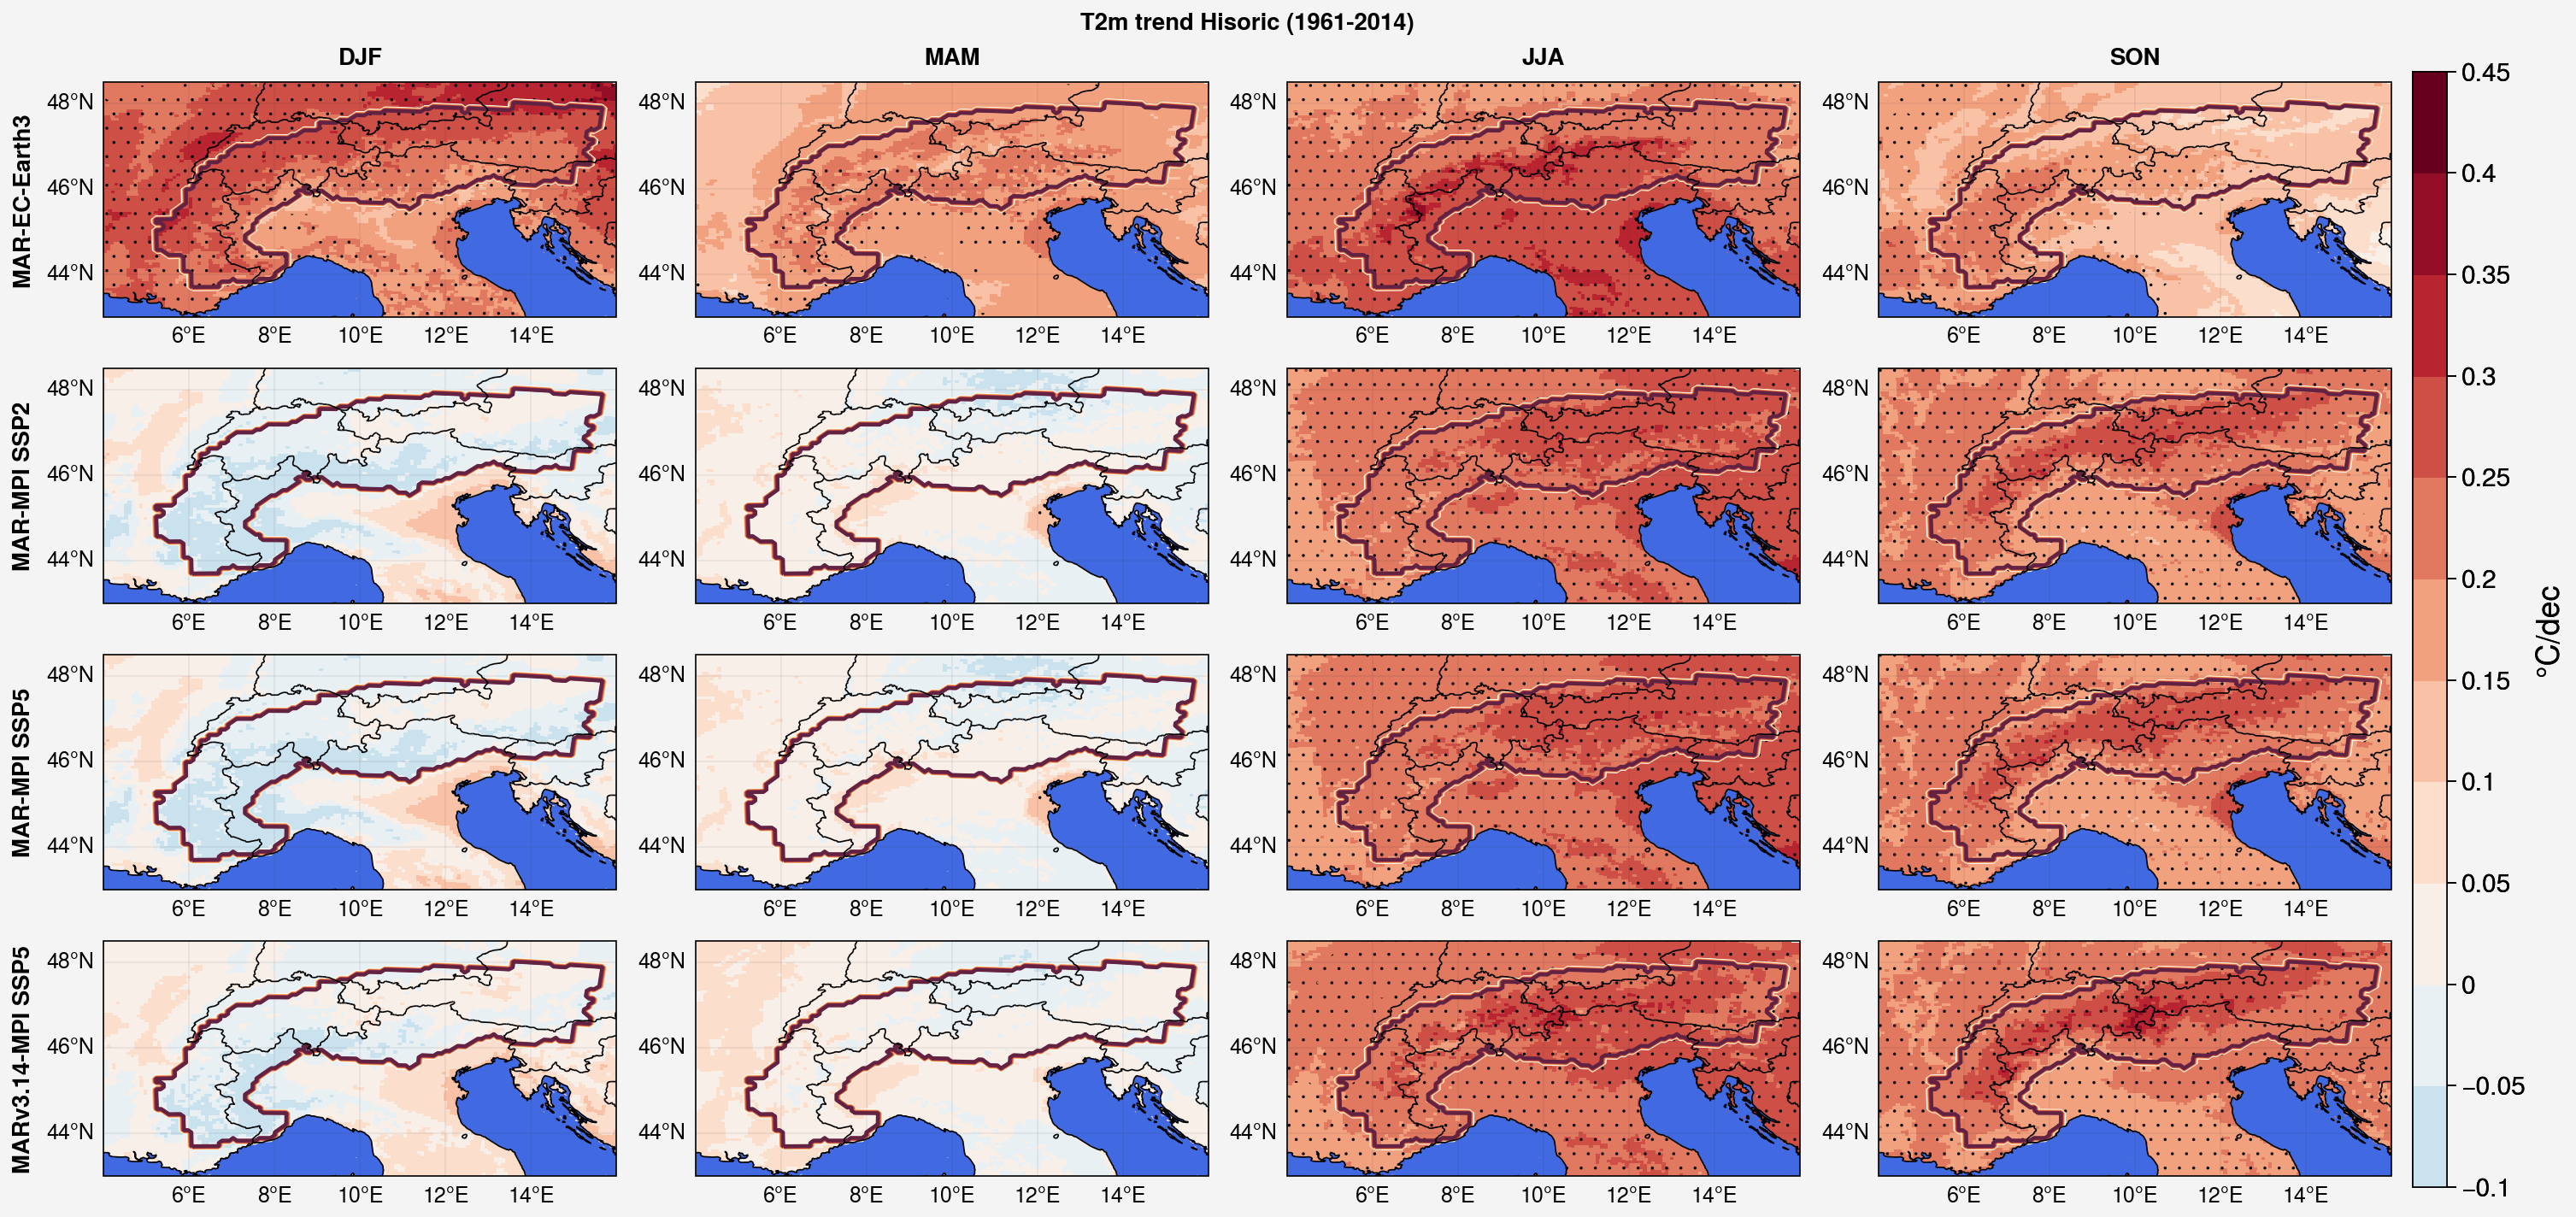

In [55]:
f, axs = pplt.subplots(proj='cyl', axwidth=3,axheight=1.5,ncols=4,nrows=4)

pvalue = 0.1
colmap = 'RdBu_r'
#levels_seas = [np.arange(-15,15,2.5),np.arange(-10,20,2.5),np.arange(-5,35,2.5),np.arange(-10,25,2.5)]
levels_seas = np.arange(-0.1,0.5,0.05)

for seas in range(4):
    m=axs[seas].pcolormesh(lon, lat, 10*slope_EC_hist[seas], levels=levels_seas,cmap=colmap)
    axs[seas].contour(lon, lat, alps)
    shade = np.where(pvalue_EC_hist[seas] < pvalue, 1, np.nan)
    axs[seas].contourf(
        lon, lat, shade,
        levels=[0.5, 1.5],
        hatches=['..'],       # dot hatch (denser than '.')
        color='none'          # don't fill, only dots
    )
    
    m2=axs[seas+4].pcolormesh(lon, lat, 10*slope_MPI_hist[seas], levels=levels_seas,cmap=colmap)
    axs[seas+4].contour(lon, lat, alps)
    shade = np.where(pvalue_MPI_hist[seas] < pvalue, 1, np.nan)
    axs[seas+4].contourf(
        lon, lat, shade,
        levels=[0.5, 1.5],
        hatches=['..'],       # dot hatch (denser than '.')
        color='none'          # don't fill, only dots
    )
    
    m2=axs[seas+8].pcolormesh(lon, lat, 10*slope_MPI_hist[seas], levels=levels_seas,cmap=colmap)
    axs[seas+8].contour(lon, lat, alps)
    shade = np.where(pvalue_MPI_hist[seas] < pvalue, 1, np.nan)
    axs[seas+8].contourf(
        lon, lat, shade,
        levels=[0.5, 1.5],
        hatches=['..'],       # dot hatch (denser than '.')
        color='none'          # don't fill, only dots
    )
    
    m2=axs[seas+12].pcolormesh(lon, lat, 10*slope_MPI_hist_314[seas], levels=levels_seas,cmap=colmap)
    axs[seas+12].contour(lon, lat, alps)
    shade = np.where(pvalue_MPI_hist_314[seas] < pvalue, 1, np.nan)
    axs[seas+12].contourf(
        lon, lat, shade,
        levels=[0.5, 1.5],
        hatches=['..'],       # dot hatch (denser than '.')
        color='none'          # don't fill, only dots
    )

f.colorbar(m,label= '°C/dec',labelsize='x-large',ticklabelsize='large')

f.format(**normal_format)
f.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[43.,48.5],lonlim=[4.,16.],collabels=['DJF','MAM','JJA','SON'],
         rowlabels=['MAR-EC-Earth3','MAR-MPI SSP2','MAR-MPI SSP5','MARv3.14-MPI SSP5'],suptitle='T2m trend Hisoric (1961-2014)')
# f.format(reso='hi', latlim=[43.,48.5],lonlim=[4.,16.],rowlabels=['DJF','MAM','JJA','SON'],
#          collabels=['EOBS','MAR-EC-Earth3 v3.10 bias','MAR-MPI v3.10 bias','MAR-MPI v3.14 bias'],suptitle='T2m 1961-2014')


/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

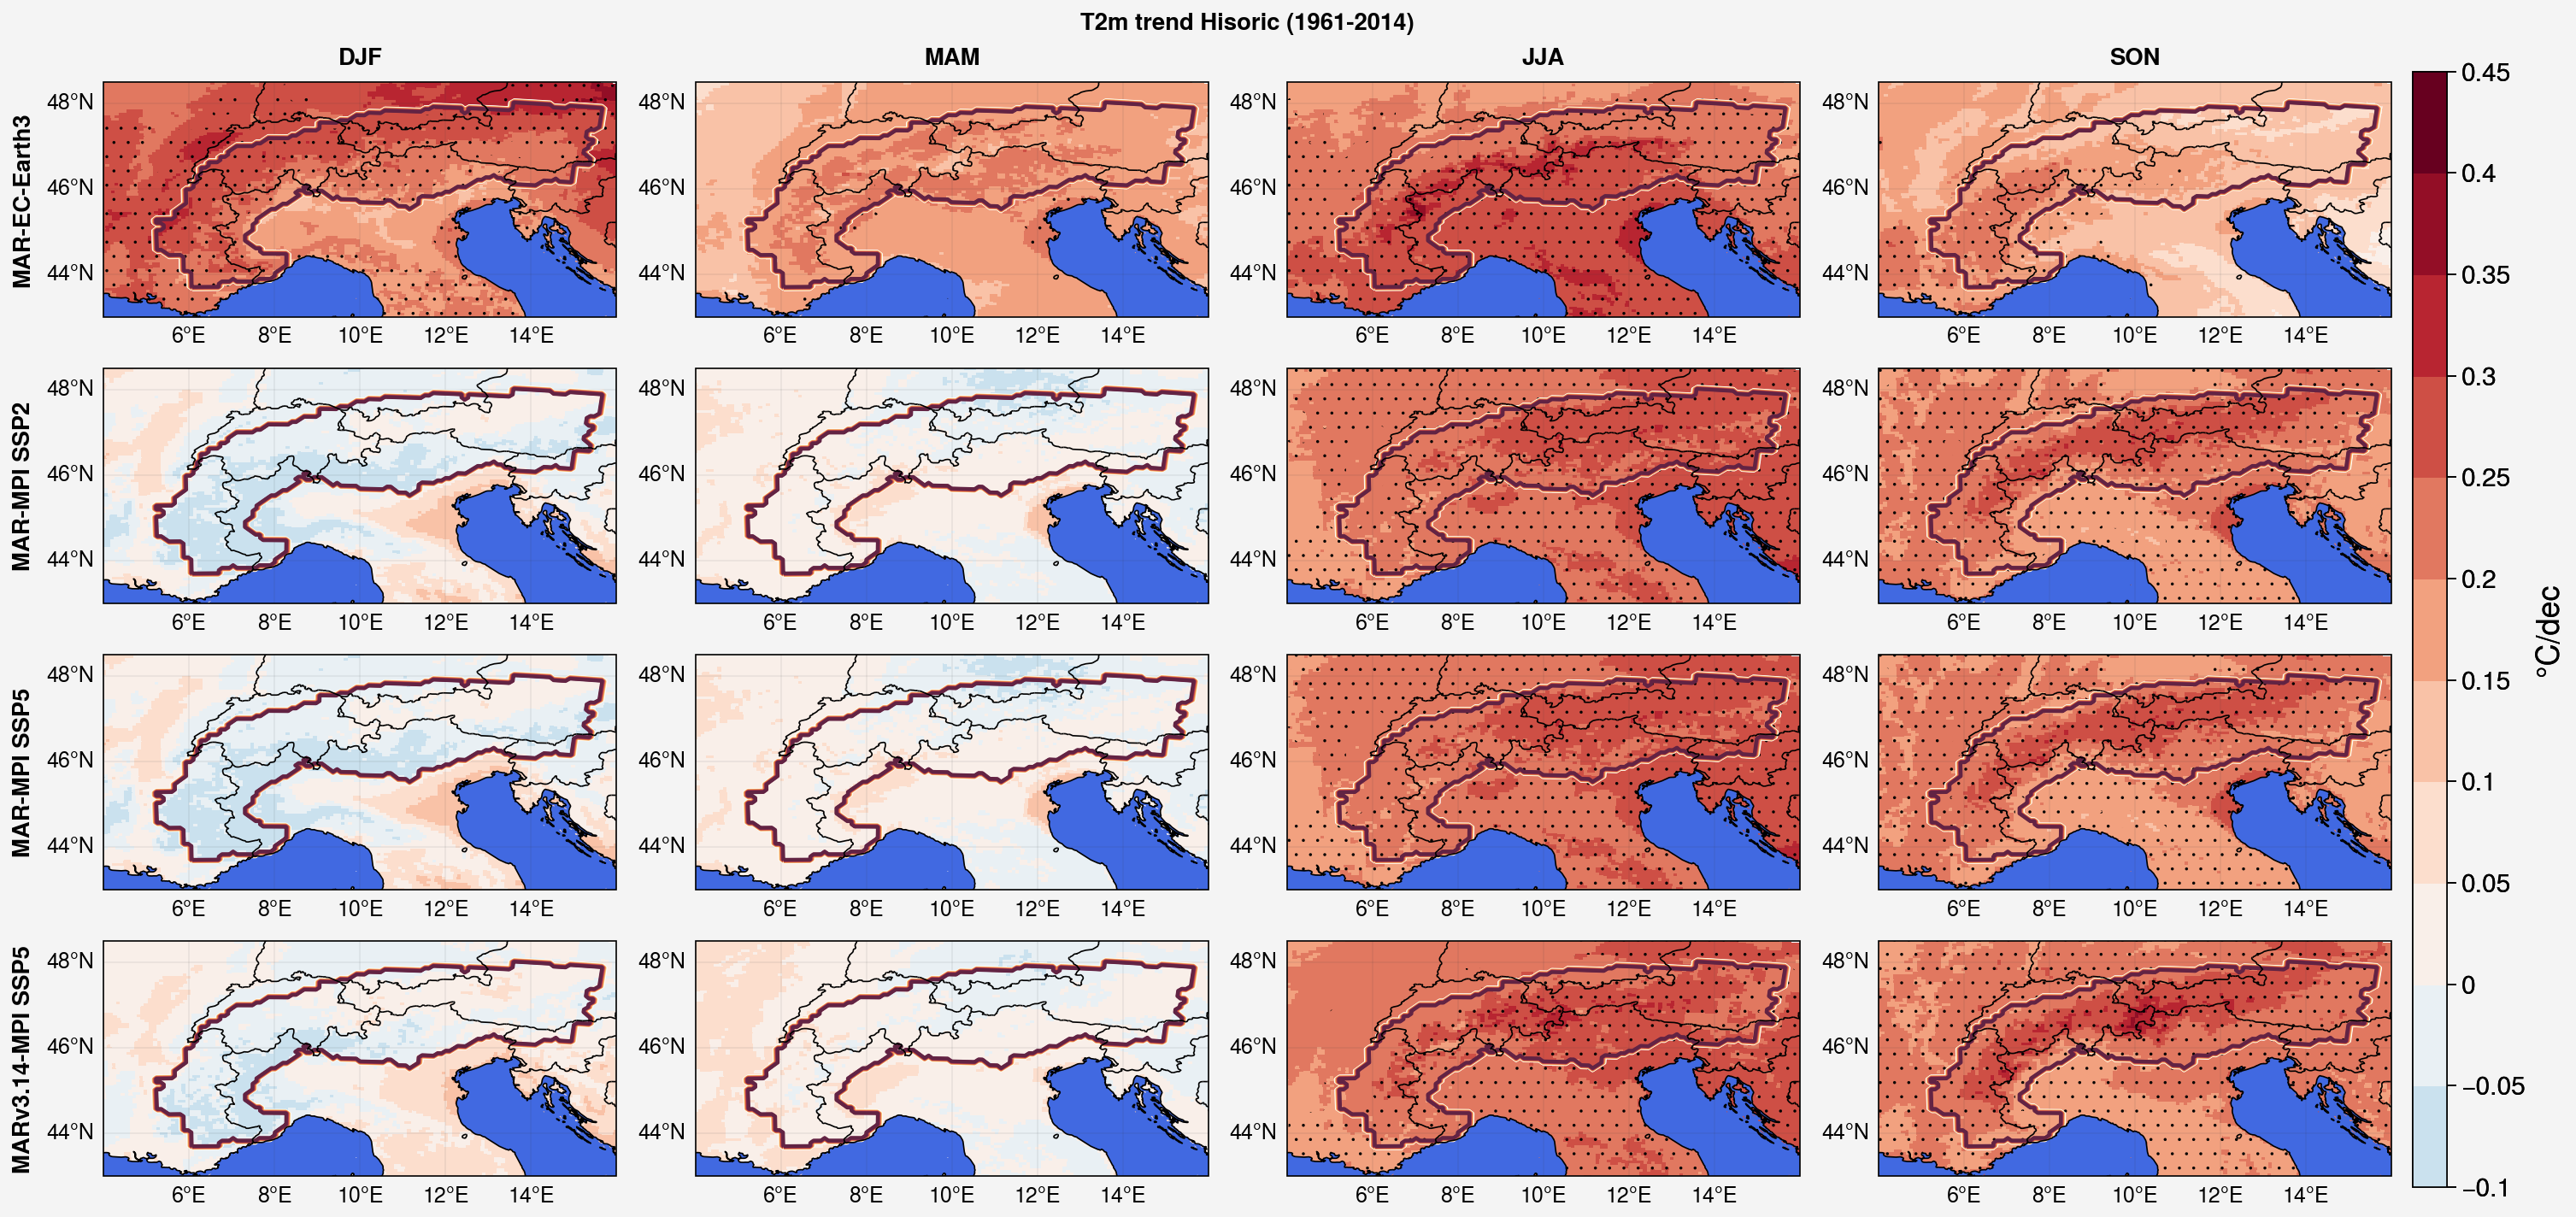

In [56]:
f, axs = pplt.subplots(proj='cyl', axwidth=3,axheight=1.5,ncols=4,nrows=4)

pvalue = 0.05
colmap = 'RdBu_r'
#levels_seas = [np.arange(-15,15,2.5),np.arange(-10,20,2.5),np.arange(-5,35,2.5),np.arange(-10,25,2.5)]
levels_seas = np.arange(-0.1,0.5,0.05)

for seas in range(4):
    m=axs[seas].pcolormesh(lon, lat, 10*slope_EC_hist[seas], levels=levels_seas,cmap=colmap)
    axs[seas].contour(lon, lat, alps)
    shade = np.where(pvalue_EC_hist[seas] < pvalue, 1, np.nan)
    axs[seas].contourf(
        lon, lat, shade,
        levels=[0.5, 1.5],
        hatches=['..'],       # dot hatch (denser than '.')
        color='none'          # don't fill, only dots
    )
    
    m2=axs[seas+4].pcolormesh(lon, lat, 10*slope_MPI_hist[seas], levels=levels_seas,cmap=colmap)
    axs[seas+4].contour(lon, lat, alps)
    shade = np.where(pvalue_MPI_hist[seas] < pvalue, 1, np.nan)
    axs[seas+4].contourf(
        lon, lat, shade,
        levels=[0.5, 1.5],
        hatches=['..'],       # dot hatch (denser than '.')
        color='none'          # don't fill, only dots
    )
    
    m2=axs[seas+8].pcolormesh(lon, lat, 10*slope_MPI_hist[seas], levels=levels_seas,cmap=colmap)
    axs[seas+8].contour(lon, lat, alps)
    shade = np.where(pvalue_MPI_hist[seas] < pvalue, 1, np.nan)
    axs[seas+8].contourf(
        lon, lat, shade,
        levels=[0.5, 1.5],
        hatches=['..'],       # dot hatch (denser than '.')
        color='none'          # don't fill, only dots
    )
    
    m2=axs[seas+12].pcolormesh(lon, lat, 10*slope_MPI_hist_314[seas], levels=levels_seas,cmap=colmap)
    axs[seas+12].contour(lon, lat, alps)
    shade = np.where(pvalue_MPI_hist_314[seas] < pvalue, 1, np.nan)
    axs[seas+12].contourf(
        lon, lat, shade,
        levels=[0.5, 1.5],
        hatches=['..'],       # dot hatch (denser than '.')
        color='none'          # don't fill, only dots
    )

f.colorbar(m,label= '°C/dec',labelsize='x-large',ticklabelsize='large')

f.format(**normal_format)
f.format(ocean=True,oceancolor='royalblue',reso='hi', latlim=[43.,48.5],lonlim=[4.,16.],collabels=['DJF','MAM','JJA','SON'],
         rowlabels=['MAR-EC-Earth3','MAR-MPI SSP2','MAR-MPI SSP5','MARv3.14-MPI SSP5'],suptitle='T2m trend Hisoric (1961-2014)')
# f.format(reso='hi', latlim=[43.,48.5],lonlim=[4.,16.],rowlabels=['DJF','MAM','JJA','SON'],
#          collabels=['EOBS','MAR-EC-Earth3 v3.10 bias','MAR-MPI v3.10 bias','MAR-MPI v3.14 bias'],suptitle='T2m 1961-2014')


### Bonus : GCM free atmosphere warming

In [42]:
path='/bettik/castelli/data/EC-Earth3/Tp/hist/'

ds_ECEarth_hist_ta = xr.open_dataset(path+'ta_Amon_EC-Earth3_historical_r25i1p1f1_gr_196001-196012.nc').sel(lon=slice(4,16),lat=slice(43,49))

In [16]:
# Nearest_s2d regrid

alps_float = alps.astype(float) # to regrid

ds_alps_mask = xr.Dataset({
    'lon': (['points'], lon.ravel()),
    'lat': (['points'], lat.ravel()),
    'mask': (['points'], alps_float.ravel())
})

ds_tgt_resolution = xr.Dataset({
    'lon': (['lon'], ds_ECEarth_hist_ta.lon.values),
    'lat': (['lat'], ds_ECEarth_hist_ta.lat.values)
})

regridder = xe.Regridder(
    ds_alps_mask, ds_tgt_resolution,
    method='nearest_s2d',
    locstream_in=True,
    periodic=True   # if your longitudes wrap 0–360
)

mask_tgt_resolution = regridder(ds_alps_mask['mask'])
mask_tgt_resolution = mask_tgt_resolution.astype(bool)   # back to boolean


/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


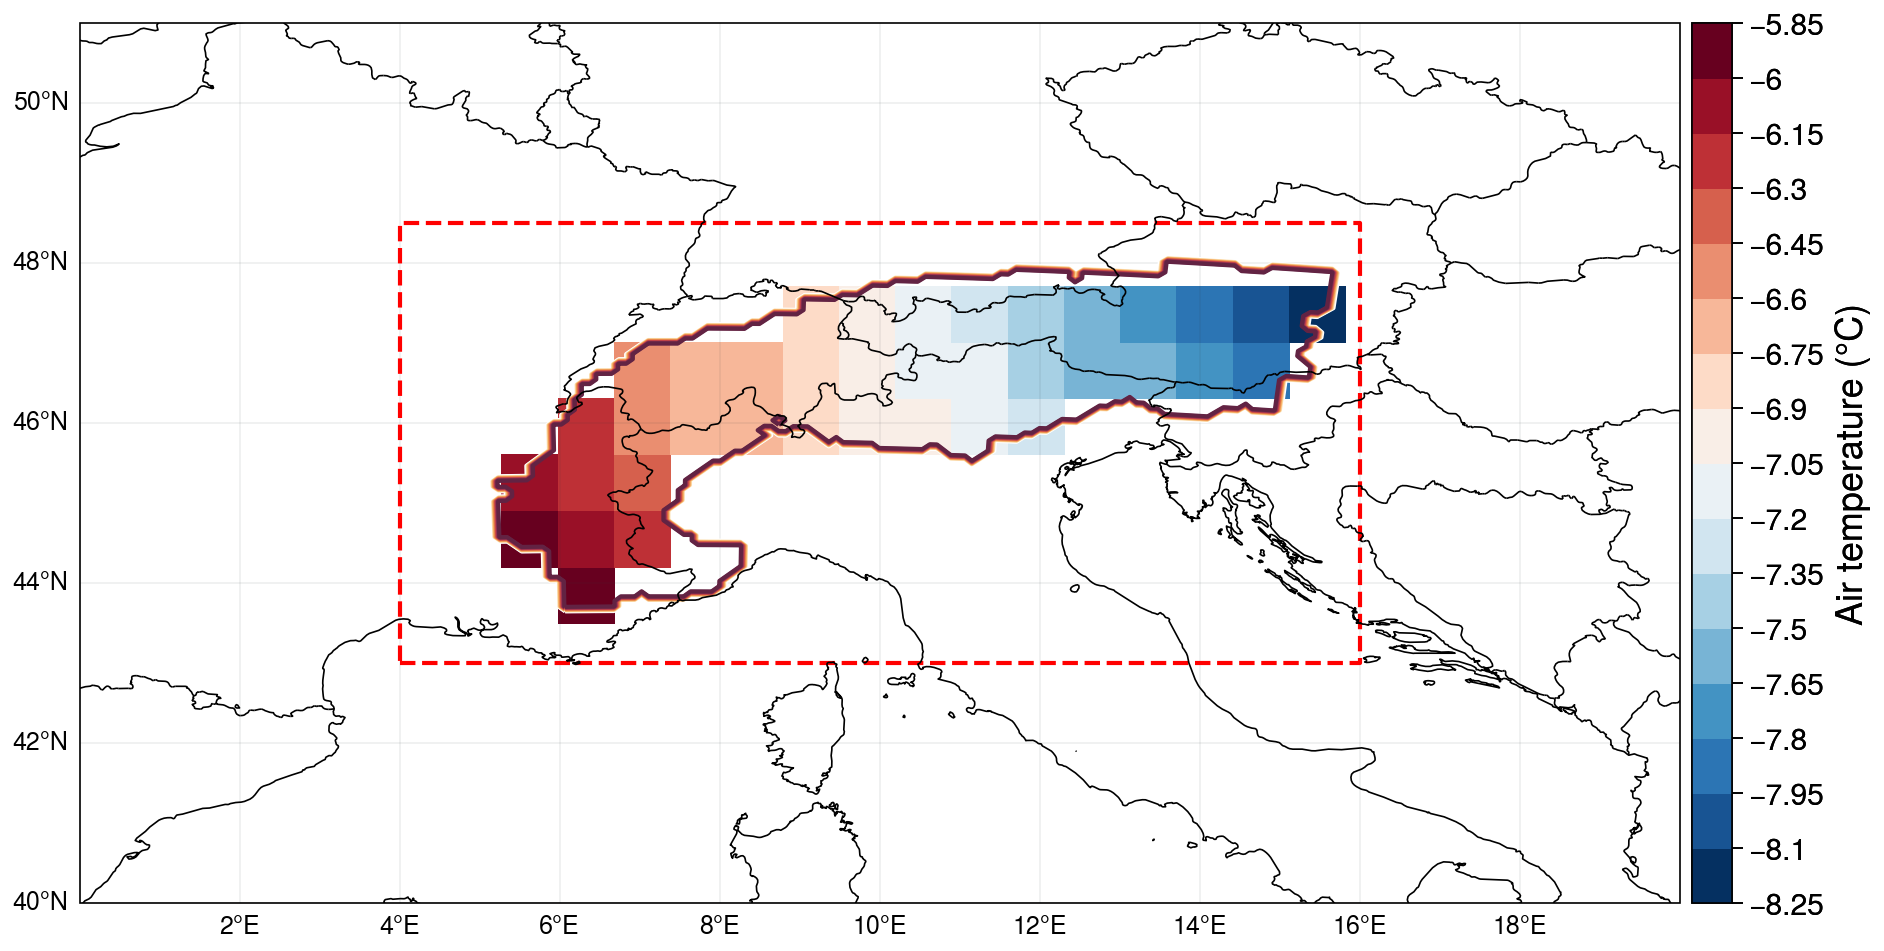

In [46]:
pplt.rc['figure.facecolor'] = 'white'
colmap = 'RdBu_r'

f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=1)

ds_plot = ds_ECEarth_hist_ta.ta.isel(time=0,plev=3).where(mask_tgt_resolution)-273.15

m=axs.pcolormesh(ds_ECEarth_hist_ta.lon, ds_ECEarth_hist_ta.lat, ds_plot, levels=17,cmap=colmap)
axs.colorbar(m,label= 'Air temperature (°C)',labelsize='x-large',ticklabelsize='large')
axs.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')
axs.contour(lon, lat, alps)
#axs.contour(ds_ECEarth_hist_ta.lon, ds_ECEarth_hist_ta.lat, mask_tgt_resolution)

f.format(**normal_format)
f.format(ocean=False,oceancolor='royalblue',reso='hi', latlim=[40.,51.],lonlim=[0.,20.])


In [47]:
# Nearest_d2s regrid

alps_float = alps.astype(float) # to regrid

ds_alps_mask = xr.Dataset({
    'lon': (['points'], lon.ravel()),
    'lat': (['points'], lat.ravel()),
    'mask': (['points'], alps_float.ravel())
})

ds_tgt_resolution = xr.Dataset({
    'lon': (['lon'], ds_ECEarth_hist_ta.lon.values),
    'lat': (['lat'], ds_ECEarth_hist_ta.lat.values)
})

regridder = xe.Regridder(
    ds_alps_mask, ds_tgt_resolution,
    method='nearest_d2s',
    locstream_in=True,
    periodic=True   # if your longitudes wrap 0–360
)

mask_tgt_resolution = regridder(ds_alps_mask['mask'])
mask_tgt_resolution = mask_tgt_resolution.astype(bool)   # back to boolean

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


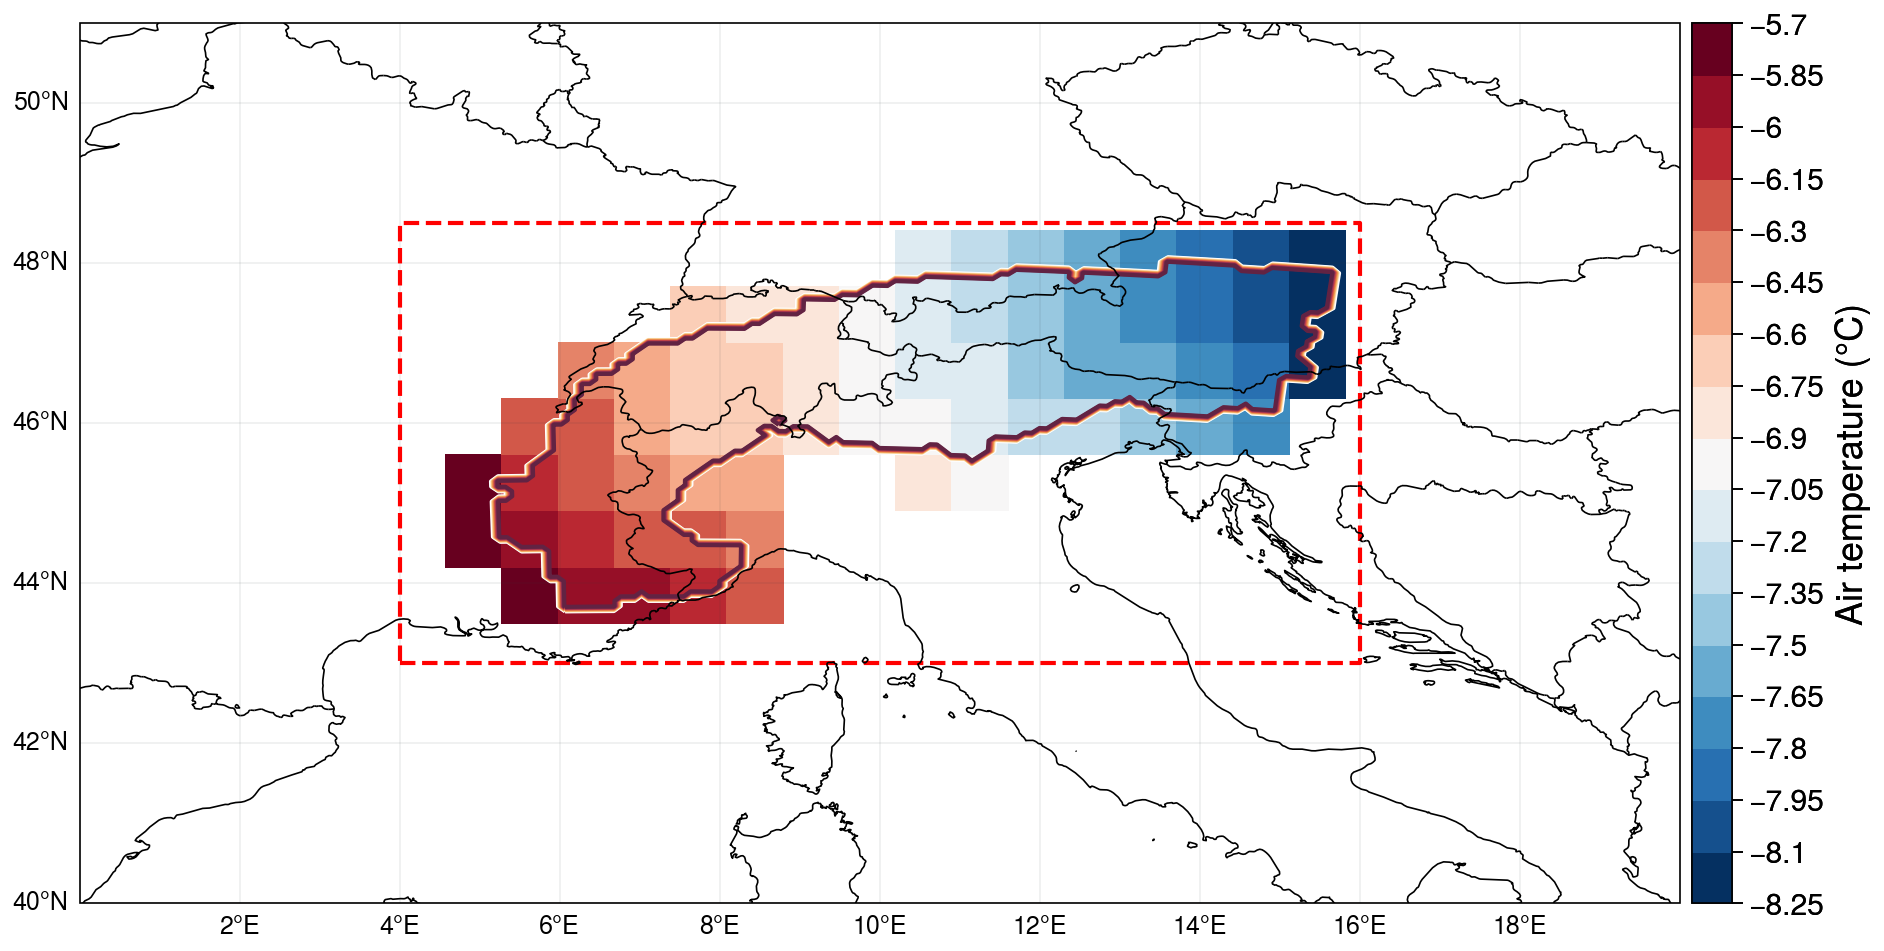

In [48]:
pplt.rc['figure.facecolor'] = 'white'
colmap = 'RdBu_r'

f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=1)

ds_plot = ds_ECEarth_hist_ta.ta.isel(time=0,plev=3).where(mask_tgt_resolution)-273.15

m=axs.pcolormesh(ds_ECEarth_hist_ta.lon, ds_ECEarth_hist_ta.lat, ds_plot, levels=17,cmap=colmap)
axs.colorbar(m,label= 'Air temperature (°C)',labelsize='x-large',ticklabelsize='large')
axs.plot([4.,16.,16,4,4],[43.,43,48.5,48.5,43],'--r')
axs.contour(lon, lat, alps)
#axs.contour(ds_ECEarth_hist_ta.lon, ds_ECEarth_hist_ta.lat, mask_tgt_resolution)

f.format(**normal_format)
f.format(ocean=False,oceancolor='royalblue',reso='hi', latlim=[40.,51.],lonlim=[0.,20.])


We choose the mask created by nearest_d2s first.

#### Preparing EC-Earth data (tricky because missing years)

In [89]:
# TTz

first_year = 1961
last_year = 2100
path='/bettik/castelli/data/EC-Earth3/Tp/'

# years 1961, 1968, 2010, 2022, 2044, 2046 are missing, so we replace them with previous year
ds_var = xr.open_dataset(path+'hist/ta_Amon_EC-Earth3_historical_r25i1p1f1_gr_196001-196012.nc').sel(lon=slice(4,16),lat=slice(43,49))
seas_ECEarth_ta = ds_var.ta.groupby('time.season').mean().sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

for year in list(range(first_year+1,last_year+1)):
    print(year,end=' ')

    if year == 1968:
        ds_var = xr.open_dataset(path+'hist/ta_Amon_EC-Earth3_historical_r25i1p1f1_gr_196701-196712.nc').sel(lon=slice(4,16),lat=slice(43,49))
    elif year == 2010:
        ds_var = xr.open_dataset(path+'hist/ta_Amon_EC-Earth3_historical_r25i1p1f1_gr_200901-200912.nc').sel(lon=slice(4,16),lat=slice(43,49))
    elif year == 2022:
        ds_var = xr.open_dataset(path+'ssp245/ta_Amon_EC-Earth3_ssp245_r25i1p1f1_gr_202101-202112.nc').sel(lon=slice(4,16),lat=slice(43,49))
    elif year == 2044:
        ds_var = xr.open_dataset(path+'ssp245/ta_Amon_EC-Earth3_ssp245_r25i1p1f1_gr_204301-204312.nc').sel(lon=slice(4,16),lat=slice(43,49))
    elif year == 2046:
        ds_var = xr.open_dataset(path+'ssp245/ta_Amon_EC-Earth3_ssp245_r25i1p1f1_gr_204501-204512.nc').sel(lon=slice(4,16),lat=slice(43,49))
    elif year <2015:
        ds_var = xr.open_dataset(path+'hist/ta_Amon_EC-Earth3_historical_r25i1p1f1_gr_'+str(year)+'01-'+str(year)+'12.nc').sel(lon=slice(4,16),lat=slice(43,49))
    else:
        ds_var = xr.open_dataset(path+'ssp245/ta_Amon_EC-Earth3_ssp245_r25i1p1f1_gr_'+str(year)+'01-'+str(year)+'12.nc').sel(lon=slice(4,16),lat=slice(43,49))

    season_mean_year = ds_var.ta.groupby('time.season').mean().sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
    seas_ECEarth_ta = xr.concat([seas_ECEarth_ta,season_mean_year], dim='Year')

yrs = np.arange(first_year,last_year+1)
seas_ECEarth_ta = seas_ECEarth_ta.assign_coords(Year=("Year", yrs))

1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094 2095 2096 2097 2098 2099 2100 

In [90]:
seas_ECEarth_ta.to_netcdf('/bettik/castelli/data/EC-Earth3/saved_data/ta_seas_1961-2100_alps.nc')

#### Load EC-Earth data

In [17]:
seas_ECEarth_ta = xr.open_dataset('/bettik/castelli/data/EC-Earth3/saved_data/ta_seas_1961-2100_alps.nc')

#### MPI data and analysis

In [18]:
path='/bettik/castelli/data/MPI-ESM1-2-HR/Tp/hist/'

ds_MPI_hist_ta = xr.open_mfdataset(path+'*.nc', combine="by_coords").sel(lon=slice(4,16),lat=slice(43,49))

In [19]:
ds_MPI_hist_ta = xr.decode_cf(ds_MPI_hist_ta)

# select season
DA_DJF = ds_MPI_hist_ta.sel(time=ds_MPI_hist_ta.time.dt.season=="DJF")
DA_MAM = ds_MPI_hist_ta.sel(time=ds_MPI_hist_ta.time.dt.season=="MAM")
DA_JJA = ds_MPI_hist_ta.sel(time=ds_MPI_hist_ta.time.dt.season=="JJA")
DA_SON = ds_MPI_hist_ta.sel(time=ds_MPI_hist_ta.time.dt.season=="SON")

# calculate mean per year
DJF_MPI_hist_ta = DA_DJF.groupby(DA_DJF.time.dt.year).mean("time")
MAM_MPI_hist_ta = DA_MAM.groupby(DA_MAM.time.dt.year).mean("time")
JJA_MPI_hist_ta = DA_JJA.groupby(DA_JJA.time.dt.year).mean("time")
SON_MPI_hist_ta = DA_SON.groupby(DA_SON.time.dt.year).mean("time")



In [20]:
seas_MPI_hist_ta = xr.concat([DJF_MPI_hist_ta, MAM_MPI_hist_ta, JJA_MPI_hist_ta, SON_MPI_hist_ta],dim="season")

seas_MPI_hist_ta = seas_MPI_hist_ta.assign_coords(season=("season", ['DJF','MAM','JJA','SON']))
seas_MPI_hist_ta

<xarray.Dataset>
Dimensions:   (plev: 19, lat: 6, season: 4, year: 165, bnds: 2, lon: 13)
Coordinates:
  * plev      (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * lat       (lat) float64 43.48 44.42 45.35 46.29 47.22 48.16
  * lon       (lon) float64 4.688 5.625 6.562 7.5 ... 13.12 14.06 15.0 15.94
  * year      (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
  * season    (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (season, year, lat, bnds) float64 dask.array<chunksize=(1, 1, 6, 2), meta=np.ndarray>
    lon_bnds  (season, year, lon, bnds) float64 dask.array<chunksize=(1, 1, 13, 2), meta=np.ndarray>
    ta        (season, year, plev, lat, lon) float32 dask.array<chunksize=(1, 1, 19, 6, 13), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            ta
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/b8813e3b-c802-470b-9194-9164e58bace9

In [21]:
seas_MPI_hist_ta = seas_MPI_hist_ta.rename({"year": "Year"})

In [22]:
path='/bettik/castelli/data/MPI-ESM1-2-HR/Tp/ssp245/'

ds_MPI_ssp245_ta = xr.open_mfdataset(path+'*.nc', combine="by_coords").sel(lon=slice(4,16),lat=slice(43,49))

In [23]:
ds_MPI_ssp245_ta = xr.decode_cf(ds_MPI_ssp245_ta)

# select season
DA_DJF = ds_MPI_ssp245_ta.sel(time=ds_MPI_ssp245_ta.time.dt.season=="DJF")
DA_MAM = ds_MPI_ssp245_ta.sel(time=ds_MPI_ssp245_ta.time.dt.season=="MAM")
DA_JJA = ds_MPI_ssp245_ta.sel(time=ds_MPI_ssp245_ta.time.dt.season=="JJA")
DA_SON = ds_MPI_ssp245_ta.sel(time=ds_MPI_ssp245_ta.time.dt.season=="SON")

# calculate mean per year
DJF_MPI_ssp245_ta = DA_DJF.groupby(DA_DJF.time.dt.year).mean("time")
MAM_MPI_ssp245_ta = DA_MAM.groupby(DA_MAM.time.dt.year).mean("time")
JJA_MPI_ssp245_ta = DA_JJA.groupby(DA_JJA.time.dt.year).mean("time")
SON_MPI_ssp245_ta = DA_SON.groupby(DA_SON.time.dt.year).mean("time")

seas_MPI_ssp245_ta = xr.concat([DJF_MPI_ssp245_ta, MAM_MPI_ssp245_ta, JJA_MPI_ssp245_ta, SON_MPI_ssp245_ta],dim="season")

seas_MPI_ssp245_ta = seas_MPI_ssp245_ta.assign_coords(season=("season", ['DJF','MAM','JJA','SON']))
seas_MPI_ssp245_ta

<xarray.Dataset>
Dimensions:   (plev: 19, lat: 6, season: 4, year: 86, bnds: 2, lon: 13)
Coordinates:
  * plev      (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * lat       (lat) float64 43.48 44.42 45.35 46.29 47.22 48.16
  * lon       (lon) float64 4.688 5.625 6.562 7.5 ... 13.12 14.06 15.0 15.94
  * year      (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * season    (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (season, year, lat, bnds) float64 dask.array<chunksize=(1, 1, 6, 2), meta=np.ndarray>
    lon_bnds  (season, year, lon, bnds) float64 dask.array<chunksize=(1, 1, 13, 2), meta=np.ndarray>
    ta        (season, year, plev, lat, lon) float32 dask.array<chunksize=(1, 1, 19, 6, 13), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            ta
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by DKRZ is licensed und...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/22d7eeb8-f917-4f1e-bc2f-e880d267989b

In [24]:
seas_MPI_ssp245_ta = seas_MPI_ssp245_ta.rename({"year": "Year"})

In [25]:
path='/bettik/castelli/data/MPI-ESM1-2-HR/Tp/ssp585/'

ds_MPI_ssp585_ta = xr.open_mfdataset(path+'*.nc', combine="by_coords").sel(lon=slice(4,16),lat=slice(43,49))

In [26]:
ds_MPI_ssp585_ta = xr.decode_cf(ds_MPI_ssp585_ta)

# select season
DA_DJF = ds_MPI_ssp585_ta.sel(time=ds_MPI_ssp585_ta.time.dt.season=="DJF")
DA_MAM = ds_MPI_ssp585_ta.sel(time=ds_MPI_ssp585_ta.time.dt.season=="MAM")
DA_JJA = ds_MPI_ssp585_ta.sel(time=ds_MPI_ssp585_ta.time.dt.season=="JJA")
DA_SON = ds_MPI_ssp585_ta.sel(time=ds_MPI_ssp585_ta.time.dt.season=="SON")

# calculate mean per year
DJF_MPI_ssp585_ta = DA_DJF.groupby(DA_DJF.time.dt.year).mean("time")
MAM_MPI_ssp585_ta = DA_MAM.groupby(DA_MAM.time.dt.year).mean("time")
JJA_MPI_ssp585_ta = DA_JJA.groupby(DA_JJA.time.dt.year).mean("time")
SON_MPI_ssp585_ta = DA_SON.groupby(DA_SON.time.dt.year).mean("time")

seas_MPI_ssp585_ta = xr.concat([DJF_MPI_ssp585_ta, MAM_MPI_ssp585_ta, JJA_MPI_ssp585_ta, SON_MPI_ssp585_ta],dim="season")

seas_MPI_ssp585_ta = seas_MPI_ssp585_ta.assign_coords(season=("season", ['DJF','MAM','JJA','SON']))
seas_MPI_ssp585_ta

<xarray.Dataset>
Dimensions:   (plev: 19, lat: 6, season: 4, year: 86, bnds: 2, lon: 13)
Coordinates:
  * plev      (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
  * lat       (lat) float64 43.48 44.42 45.35 46.29 47.22 48.16
  * lon       (lon) float64 4.688 5.625 6.562 7.5 ... 13.12 14.06 15.0 15.94
  * year      (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
  * season    (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (season, year, lat, bnds) float64 dask.array<chunksize=(1, 1, 6, 2), meta=np.ndarray>
    lon_bnds  (season, year, lon, bnds) float64 dask.array<chunksize=(1, 1, 13, 2), meta=np.ndarray>
    ta        (season, year, plev, lat, lon) float32 dask.array<chunksize=(1, 1, 19, 6, 13), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60265.0
    branch_time_in_parent:  60265.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            ta
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by DKRZ is licensed und...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/ec28dd69-8d34-48fe-9fdf-9fa6e7167284

In [27]:
seas_MPI_ssp585_ta = seas_MPI_ssp585_ta.rename({"year": "Year"})

In [28]:
def making_slopes_freeatm_GCM(ds_hist, ds_fut,alps_msk):
    #msk_TTp = np.logical_and(ds_hist.TTp.mean(axis=0) < 1000, ds_fut.TTp.mean(axis=0) < 1000) # 1000:arbitrary value, we just want to filter 10**(34) values

    #alps_TTp = np.logical_and(alps,msk_TTp)
    
    ds_slopes_hist = ds_hist.polyfit('Year', deg=1)
    ds_slopes_Hlev_hist_TTp = ds_slopes_hist.sel(degree=1).ta_polyfit_coefficients.where(alps_msk).mean(dim=('lat','lon'))
    ds_slopes_Hlev_hist_std_TTp = ds_slopes_hist.sel(degree=1).ta_polyfit_coefficients.where(alps_msk).std(dim=('lat','lon'))

    ds_slopes_fut = ds_fut.polyfit('Year', deg=1)
    ds_slopes_Hlev_fut_TTp = ds_slopes_fut.sel(degree=1).ta_polyfit_coefficients.where(alps_msk).mean(dim=('lat','lon'))
    ds_slopes_Hlev_fut_std_TTp = ds_slopes_fut.sel(degree=1).ta_polyfit_coefficients.where(alps_msk).std(dim=('lat','lon'))

    return ds_slopes_Hlev_hist_TTp, ds_slopes_Hlev_hist_std_TTp, ds_slopes_Hlev_fut_TTp, ds_slopes_Hlev_fut_std_TTp

In [29]:
# Nearest_d2s regrid - MPI mask

alps_float = alps.astype(float) # to regrid

ds_alps_mask = xr.Dataset({
    'lon': (['points'], lon.ravel()),
    'lat': (['points'], lat.ravel()),
    'mask': (['points'], alps_float.ravel())
})

ds_tgt_resolution = xr.Dataset({
    'lon': (['lon'], ds_MPI_hist_ta.lon.values),
    'lat': (['lat'], ds_MPI_hist_ta.lat.values)
})

regridder = xe.Regridder(
    ds_alps_mask, ds_tgt_resolution,
    method='nearest_d2s',
    locstream_in=True,
    periodic=True   # if your longitudes wrap 0–360
)

mask_MPI_alps = regridder(ds_alps_mask['mask'])
mask_MPI_alps = mask_MPI_alps.astype(bool)   # back to boolean

In [30]:
slopes_MPI_hist, slopes_MPI_hist_std, \
slopes_MPI_fut_ssp245, slopes_MPI_fut_ssp245_std = making_slopes_freeatm_GCM(seas_MPI_hist_ta.sel(Year=slice(1961,2015)),
                                                               seas_MPI_ssp245_ta.sel(Year=slice(2015,2101)),
                                                               mask_MPI_alps)

slopes_MPI_hist, slopes_MPI_hist_std, \
slopes_MPI_fut_ssp585, slopes_MPI_fut_ssp585_std = making_slopes_freeatm_GCM(seas_MPI_hist_ta.sel(Year=slice(1961,2015)),
                                                               seas_MPI_ssp585_ta.sel(Year=slice(2015,2101)),
                                                               mask_MPI_alps)

In [31]:
# Nearest_d2s regrid - EC-Earth mask

alps_float = alps.astype(float) # to regrid

ds_alps_mask = xr.Dataset({
    'lon': (['points'], lon.ravel()),
    'lat': (['points'], lat.ravel()),
    'mask': (['points'], alps_float.ravel())
})

ds_tgt_resolution = xr.Dataset({
    'lon': (['lon'], ds_ECEarth_hist_ta.lon.values),
    'lat': (['lat'], ds_ECEarth_hist_ta.lat.values)
})

regridder = xe.Regridder(
    ds_alps_mask, ds_tgt_resolution,
    method='nearest_d2s',
    locstream_in=True,
    periodic=True   # if your longitudes wrap 0–360
)

mask_ECEarth_alps = regridder(ds_alps_mask['mask'])
mask_ECEarth_alps = mask_ECEarth_alps.astype(bool)   # back to boolean

In [32]:
slopes_ECEarth_hist, slopes_ECEarth_hist_std, \
slopes_ECEarth_fut, slopes_ECEarth_fut_std = making_slopes_freeatm_GCM(seas_ECEarth_ta.sel(Year=slice(1961,2015)),
                                                                       seas_ECEarth_ta.sel(Year=slice(2015,2101)),
                                                                       mask_ECEarth_alps)

In [33]:
seas=0
slopes_ECEarth_hist.plev.values

array([100000.,  92500.,  85000.,  70000.,  60000.,  50000.,  40000.,
        30000.,  25000.,  20000.,  15000.,  10000.,   7000.,   5000.,
         3000.,   2000.,   1000.,    500.,    100.])

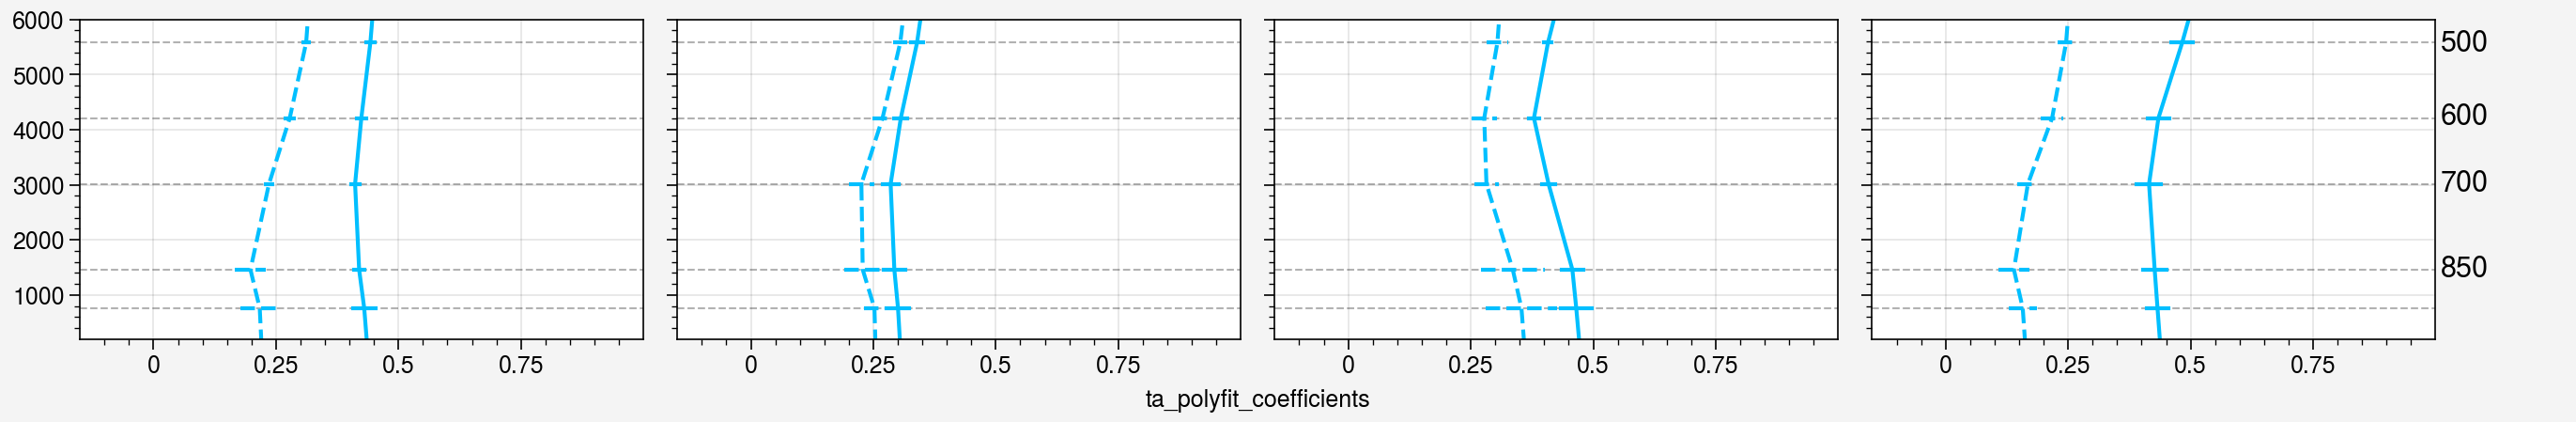

In [34]:
f, axs = pplt.subplots(ncols=4,nrows=1,axheight=1.7,axwidth=3,right=6)

multiplier=10
H_levels_pressure = H_levels_pressure_GCM

for sim in range(1):
    for seas in range(4):
        ax = axs[seas+4*sim]

        for m in range(len(H_levels_pressure)):
            ax.plot([-0.15,1.9],[H_levels_pressure[m],H_levels_pressure[m]],linestyle='--',c='k',linewidth=0.75,alpha=0.3)
        
        ax.plot(multiplier*slopes_ECEarth_hist.isel(season=seas)[:10],H_levels_pressure,c='deepskyblue',linestyle='--')
        ax.plot(multiplier*slopes_ECEarth_fut.isel(season=seas)[:10],H_levels_pressure,c='deepskyblue')
        for lev in range(len(H_levels_pressure)): # spatial standard deviation
            if lev<len(H_levels_pressure):
                var='TTp'
                slope_var = slopes_ECEarth_hist.isel(season=seas)[lev]
                std_var = slopes_ECEarth_hist_std.isel(season=seas)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels_pressure[lev],H_levels_pressure[lev]],c='deepskyblue',
                            linestyle='--')

                slope_var = slopes_ECEarth_fut.isel(season=seas)[lev]
                std_var = slopes_ECEarth_fut_std.isel(season=seas)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels_pressure[lev],H_levels_pressure[lev]],c='deepskyblue')

        ax.set_xlim(-0.15,1.0)
        ax.set_xticks(np.arange(0.,1.,0.25))
        ax.set_ylim(200,6000)

        if seas==3:
            if len(H_levels_pressure) == 7:
                ax.text(1.01, 650, "925", fontsize=11)
                ax.text(1.01, 1840, "800", fontsize=11)
            ax.text(1.01, 1340, "850", fontsize=11)
            ax.text(1.01, 2880, "700", fontsize=11)
            ax.text(1.01, 4100, "600", fontsize=11)
            ax.text(1.01, 5430, "500", fontsize=11)




In [58]:
def plot_ground_freeatm_GCM(ds_in_hist1,ds_in_fut1,ds_in_hist2,ds_in_fut2,ds_in_hist3,ds_in_fut3,ds_in_hist4,ds_in_fut4,multiplier=10,label_on_left='',
                           H_levels_pressure=H_levels_pressure):
    # multiplier =10 if trends per decade
    pplt.rc.update(small=12, large=12)

    H_levels_pressure314 = [1460,3015,4210,5580,11785]
    seasons=['DJF','MAM','JJA','SON']
    # mask for under-the-surface values at 800hPa and other pressures

    ds1_slopes_Hlev_hist, ds1_slopes_Hlev_hist_std, ds1_slopes_Hlev_hist_TTp, ds1_slopes_Hlev_hist_std_TTp, ds1_slopes_Hlev_fut, ds1_slopes_Hlev_fut_std, \
    ds1_slopes_Hlev_fut_TTp, ds1_slopes_Hlev_fut_std_TTp = making_slopes_gd_freeatm(ds_in_hist1, ds_in_fut1)

    ds2_slopes_Hlev_hist, ds2_slopes_Hlev_hist_std, ds2_slopes_Hlev_hist_TTp, ds2_slopes_Hlev_hist_std_TTp, ds2_slopes_Hlev_fut, ds2_slopes_Hlev_fut_std, \
    ds2_slopes_Hlev_fut_TTp, ds2_slopes_Hlev_fut_std_TTp = making_slopes_gd_freeatm(ds_in_hist2, ds_in_fut2)

    ds3_slopes_Hlev_hist, ds3_slopes_Hlev_hist_std, ds3_slopes_Hlev_hist_TTp, ds3_slopes_Hlev_hist_std_TTp, ds3_slopes_Hlev_fut, ds3_slopes_Hlev_fut_std, \
    ds3_slopes_Hlev_fut_TTp, ds3_slopes_Hlev_fut_std_TTp = making_slopes_gd_freeatm(ds_in_hist3, ds_in_fut3)

    ds4_slopes_Hlev_hist, ds4_slopes_Hlev_hist_std, ds4_slopes_Hlev_hist_TTp, ds4_slopes_Hlev_hist_std_TTp, ds4_slopes_Hlev_fut, ds4_slopes_Hlev_fut_std, \
    ds4_slopes_Hlev_fut_TTp, ds4_slopes_Hlev_fut_std_TTp = making_slopes_gd_freeatm(ds_in_hist4, ds_in_fut4)
    
    list_slopes_Hlev_hist=[[ds1_slopes_Hlev_hist.values,ds2_slopes_Hlev_hist.values,ds3_slopes_Hlev_hist.values,ds4_slopes_Hlev_hist.values],
                           [ds1_slopes_Hlev_hist_std.values,ds2_slopes_Hlev_hist_std.values,ds3_slopes_Hlev_hist_std.values,ds4_slopes_Hlev_hist_std.values]]
    list_slopes_Hlev_hist_TTp=[[ds1_slopes_Hlev_hist_TTp.values,ds2_slopes_Hlev_hist_TTp.values,ds3_slopes_Hlev_hist_TTp.values,ds4_slopes_Hlev_hist_TTp.values],
                               [ds1_slopes_Hlev_hist_std_TTp.values,ds2_slopes_Hlev_hist_std_TTp.values,ds3_slopes_Hlev_hist_std_TTp.values,
                                ds4_slopes_Hlev_hist_std_TTp.values]]
    list_slopes_hist_GCM=[[slopes_ECEarth_hist[:,:10].values,slopes_MPI_hist[:,:10].values,slopes_MPI_hist[:,:10].values,slopes_MPI_hist[:,:10].values],
                          [slopes_ECEarth_hist_std[:,:10].values,slopes_MPI_hist_std[:,:10].values,slopes_MPI_hist_std[:,:10].values,
                           slopes_MPI_hist_std[:,:10].values]]
    
    list_slopes_Hlev_fut=[[ds1_slopes_Hlev_fut.values,ds2_slopes_Hlev_fut.values,ds3_slopes_Hlev_fut.values,ds4_slopes_Hlev_fut.values],
                          [ds1_slopes_Hlev_fut_std.values,ds2_slopes_Hlev_fut_std.values,ds3_slopes_Hlev_fut_std.values,ds4_slopes_Hlev_fut_std.values]]
    list_slopes_Hlev_fut_TTp=[[ds1_slopes_Hlev_fut_TTp.values,ds2_slopes_Hlev_fut_TTp.values,ds3_slopes_Hlev_fut_TTp.values,ds4_slopes_Hlev_fut_TTp.values],
                              [ds1_slopes_Hlev_fut_std_TTp.values,ds2_slopes_Hlev_fut_std_TTp.values,ds3_slopes_Hlev_fut_std_TTp.values,
                               ds4_slopes_Hlev_fut_std_TTp.values]]
    list_slopes_fut_GCM=[[slopes_ECEarth_fut[:,:10].values,slopes_MPI_fut_ssp245[:,:10].values,slopes_MPI_fut_ssp585[:,:10].values,
                          slopes_MPI_fut_ssp585[:,:10].values],
                          [slopes_ECEarth_fut_std[:,:10].values,slopes_MPI_fut_ssp245_std[:,:10].values,slopes_MPI_fut_ssp585_std[:,:10].values,
                           slopes_MPI_fut_ssp585_std[:,:10].values]]

    
    f, axs = pplt.subplots(ncols=4,nrows=4,axheight=1.7,axwidth=3,right=6)

    for sim in range(len(list_slopes_Hlev_hist[0])):
        print("sim = ",sim,end=" ")
        for seas in range(4):
            print(seas,end=" ")
            ax = axs[seas+4*sim]
            if len(list_slopes_Hlev_hist_TTp[0][sim][seas]) == len(H_levels_pressure):
                #print(list_slopes_Hlev_hist_TTp[0][sim].isel(season=seas).shape)
                H_levels_pressure = H_levels_pressure
            else:
                #print('else')
                #print(list_slopes_Hlev_hist_TTp[0][sim].isel(season=seas).shape)
                H_levels_pressure = H_levels_pressure314
            for m in range(len(H_levels_pressure)):
                ax.plot([-0.15,1.9],[H_levels_pressure[m],H_levels_pressure[m]],linestyle='--',c='k',linewidth=0.75,alpha=0.3)
            
            ax.plot(multiplier * list_slopes_Hlev_hist[0][sim][:, seas], H_levels,c='sienna',linestyle='--')
            ax.plot(multiplier*list_slopes_Hlev_fut[0][sim][:, seas],H_levels,c='sienna')
            
            ax.plot(multiplier*list_slopes_Hlev_hist_TTp[0][sim][seas],H_levels_pressure,c='deepskyblue',linestyle='--')
            ax.plot(multiplier*list_slopes_Hlev_fut_TTp[0][sim][seas],H_levels_pressure,c='deepskyblue')
            
            ax.plot(multiplier*list_slopes_hist_GCM[0][sim][seas],H_levels_pressure_GCM,c='k',linestyle='--')
            ax.plot(multiplier*list_slopes_fut_GCM[0][sim][seas],H_levels_pressure_GCM,c='k')
            for lev in range(len(levels)): # spatial standard deviation
                print(lev,end=" ")
                var='TTz'
                slope_var = list_slopes_Hlev_hist[0][sim][lev, seas]
                std_var   = list_slopes_Hlev_hist[1][sim][lev, seas] # std
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c='sienna')

                slope_var = list_slopes_Hlev_fut[0][sim][lev, seas]
                std_var   = list_slopes_Hlev_fut[1][sim][lev, seas]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels[lev],H_levels[lev]],c='sienna')

                if lev<len(H_levels_pressure):
                    var='TTp'
                    slope_var = list_slopes_Hlev_hist_TTp[0][sim][seas, lev]
                    std_var   = list_slopes_Hlev_hist_TTp[1][sim][seas, lev]
                    ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels_pressure[lev],H_levels_pressure[lev]],c='deepskyblue',
                            linestyle='--')

                    slope_var = list_slopes_Hlev_fut_TTp[0][sim][seas, lev]
                    std_var   = list_slopes_Hlev_fut_TTp[1][sim][seas, lev]
                    ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels_pressure[lev],H_levels_pressure[lev]],c='deepskyblue')

                if lev<len(H_levels_pressure_GCM):
                    var='ta'
                    slope_var = list_slopes_hist_GCM[0][sim][seas, lev]
                    std_var   = list_slopes_hist_GCM[1][sim][seas, lev]
                    ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels_pressure_GCM[lev],H_levels_pressure_GCM[lev]],c='k',
                            linestyle='--')

                    slope_var = list_slopes_fut_GCM[0][sim][seas, lev]
                    std_var   = list_slopes_fut_GCM[1][sim][seas, lev]
                    ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels_pressure_GCM[lev],H_levels_pressure_GCM[lev]],c='k')

            ax.set_xlim(-0.15,1.0)
            ax.set_xticks(np.arange(0.,1.,0.25))
            ax.set_ylim(200,12000)

            if seas==3:
                if len(H_levels_pressure) == 7:
                    ax.text(1.01, 650, "925", fontsize=11)
                    ax.text(1.01, 1840, "800", fontsize=11)
                ax.text(1.01, 1340, "850", fontsize=11)
                ax.text(1.01, 2880, "700", fontsize=11)
                ax.text(1.01, 4100, "600", fontsize=11)
                ax.text(1.01, 5430, "500", fontsize=11)
                ax.text(0.61, 11650, "200", fontsize=9)
                # if seas==2:
                #     ax.text(1.08,6000,'Pressure (hPa)',rotation='vertical',fontsize=12,wrap=False)

    #f.subplots_adjust(right=0.85)
    # Add manual subplot labels (a–h, for example)
    letters = list(string.ascii_lowercase)  # ['a','b','c',...]
    labels = letters[:len(axs)]  # e.g. ['a','b','c','d'] or ['e','f','g','h']

    # You can offset starting letter manually (e.g. start at 'e')
    start_index = 0  # 0-based, so 4 = 'e'
    labels = letters[start_index:start_index+len(axs)]

    for i, ax in enumerate(axs):
        ax.text(
            0.02, 0.95, f"({labels[i]})",
            transform=ax.transAxes,
            fontsize=13,
            fontweight='bold',
            va='top', ha='left'
        )
    f.text(0.975,0.45,'Pressure (hPa)',rotation='vertical',fontsize=12)
    axs.format(collabels=['DJF','MAM','JJA', 'SON'],xlabel='T trend (°C/decade)',ylabel='Elevation (m.a.s.l.)',rowlabels=label_on_left)

/tmp/ipykernel_3334984/957985687.py:4: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=12)
/tmp/ipykernel_3334984/957985687.py:4: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=12)


sim =  0 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 3 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 sim =  1 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 3 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 sim =  2 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 3 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 sim =  3 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 3 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 

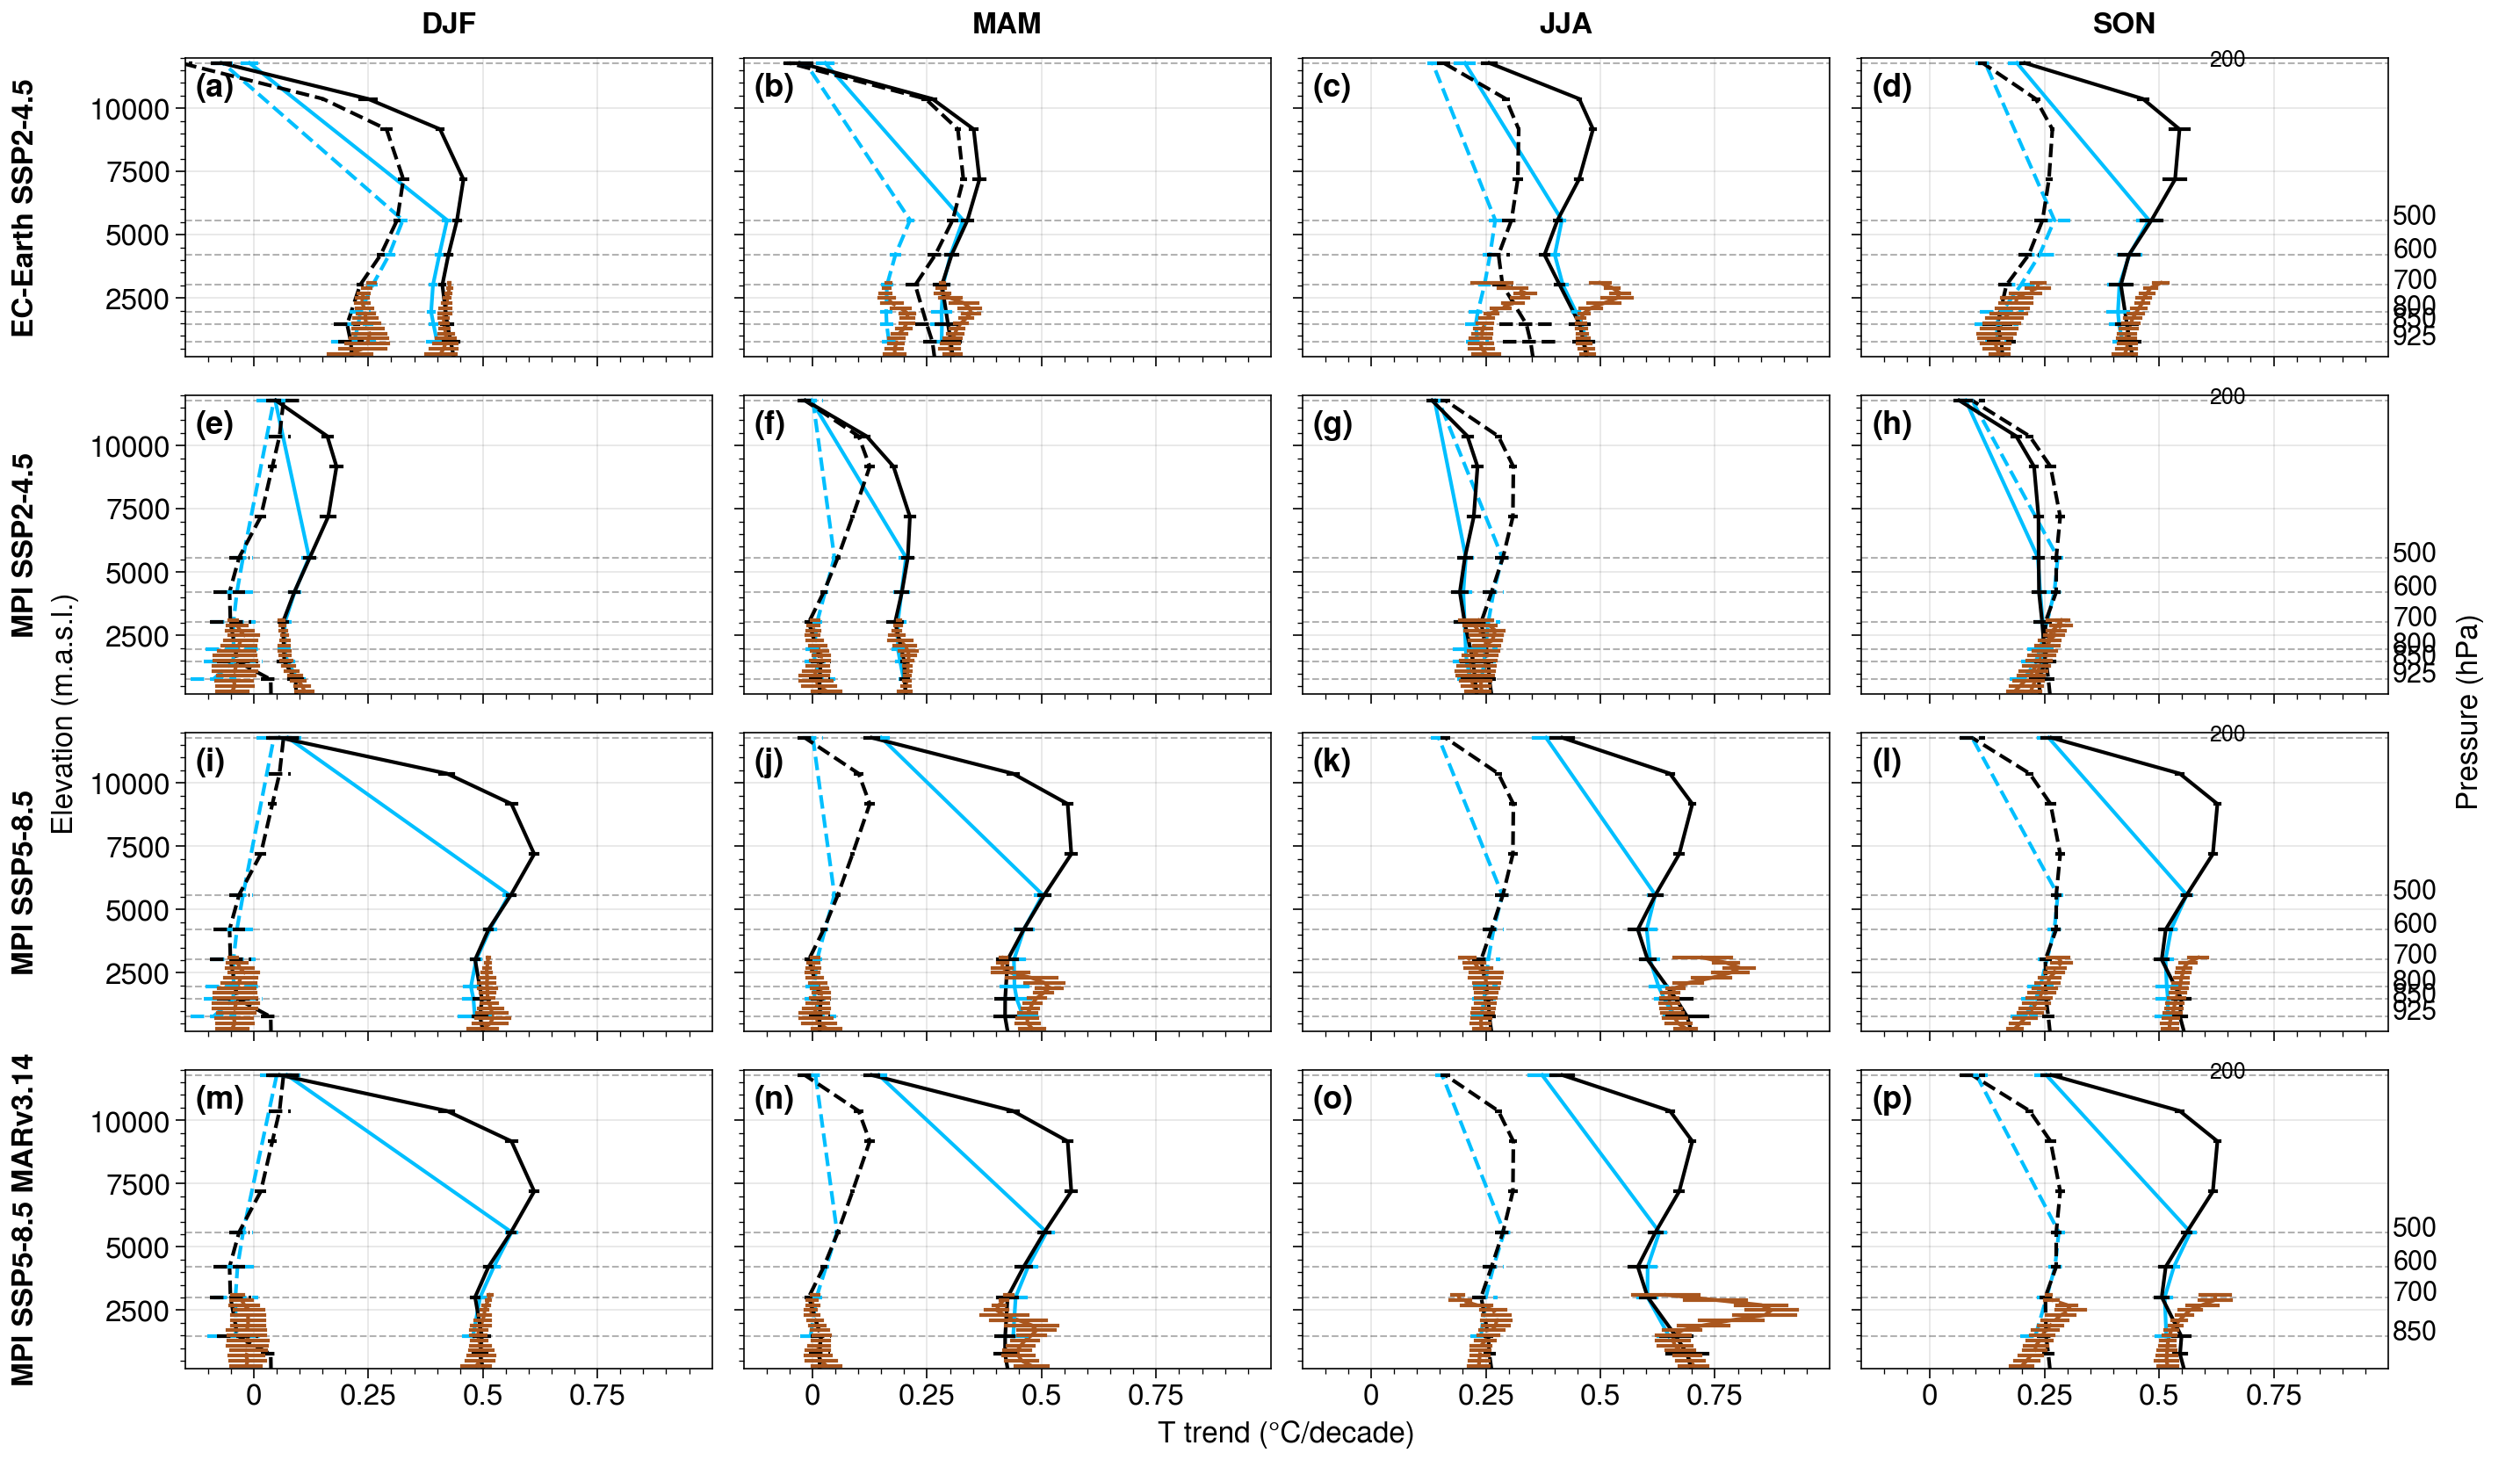

In [59]:
pplt.rc['figure.facecolor'] = 'white'

plot_ground_freeatm_GCM(ds_in_hist1 = ds_ECEarth_hist_TTz_TTp.isel(ztqlev=0), ds_in_fut1 = ds_ECEarth_SSP245_TTz_TTp.isel(ztqlev=0),
                    ds_in_hist2 = ds_MPI_hist_TTz_TTp.isel(ztqlev=0), ds_in_fut2 = ds_MPI_SSP245_TTz_TTp.isel(ztqlev=0),
                    ds_in_hist3 = ds_MPI_hist_TTz_TTp.isel(ztqlev=0), ds_in_fut3 = ds_MPI_SSP585_TTz_TTp.isel(ztqlev=0),
                    ds_in_hist4 = ds314_MPI_hist_TTz_TTp.isel(ztqlev=0), ds_in_fut4 = ds314_MPI_SSP585_TTz_TTp.isel(ztqlev=0),
                    label_on_left=["EC-Earth SSP2-4.5","MPI SSP2-4.5","MPI SSP5-8.5","MPI SSP5-8.5 MARv3.14"],
                       H_levels_pressure = [760,1460,1950,3015,4210,5580,11785])

#### nearest_s2d ?

In [52]:
# Nearest_s2d regrid - MPI mask

alps_float = alps.astype(float) # to regrid

ds_alps_mask = xr.Dataset({
    'lon': (['points'], lon.ravel()),
    'lat': (['points'], lat.ravel()),
    'mask': (['points'], alps_float.ravel())
})

ds_tgt_resolution = xr.Dataset({
    'lon': (['lon'], ds_MPI_hist_ta.lon.values),
    'lat': (['lat'], ds_MPI_hist_ta.lat.values)
})

regridder = xe.Regridder(
    ds_alps_mask, ds_tgt_resolution,
    method='nearest_s2d',
    locstream_in=True,
    periodic=True   # if your longitudes wrap 0–360
)

mask_MPI_alps = regridder(ds_alps_mask['mask'])
mask_MPI_alps = mask_MPI_alps.astype(bool)   # back to boolean

In [53]:
slopes_MPI_hist, slopes_MPI_hist_std, \
slopes_MPI_fut_ssp245, slopes_MPI_fut_ssp245_std = making_slopes_freeatm_GCM(seas_MPI_hist_ta.sel(Year=slice(1961,2015)),
                                                               seas_MPI_ssp245_ta.sel(Year=slice(2015,2101)),
                                                               mask_MPI_alps)

slopes_MPI_hist, slopes_MPI_hist_std, \
slopes_MPI_fut_ssp585, slopes_MPI_fut_ssp585_std = making_slopes_freeatm_GCM(seas_MPI_hist_ta.sel(Year=slice(1961,2015)),
                                                               seas_MPI_ssp585_ta.sel(Year=slice(2015,2101)),
                                                               mask_MPI_alps)

In [54]:
# Nearest_s2d regrid - EC-Earth mask

alps_float = alps.astype(float) # to regrid

ds_alps_mask = xr.Dataset({
    'lon': (['points'], lon.ravel()),
    'lat': (['points'], lat.ravel()),
    'mask': (['points'], alps_float.ravel())
})

ds_tgt_resolution = xr.Dataset({
    'lon': (['lon'], ds_ECEarth_hist_ta.lon.values),
    'lat': (['lat'], ds_ECEarth_hist_ta.lat.values)
})

regridder = xe.Regridder(
    ds_alps_mask, ds_tgt_resolution,
    method='nearest_s2d',
    locstream_in=True,
    periodic=True   # if your longitudes wrap 0–360
)

mask_ECEarth_alps = regridder(ds_alps_mask['mask'])
mask_ECEarth_alps = mask_ECEarth_alps.astype(bool)   # back to boolean

In [55]:
slopes_ECEarth_hist, slopes_ECEarth_hist_std, \
slopes_ECEarth_fut, slopes_ECEarth_fut_std = making_slopes_freeatm_GCM(seas_ECEarth_ta.sel(Year=slice(1961,2015)),
                                                                       seas_ECEarth_ta.sel(Year=slice(2015,2101)),
                                                                       mask_ECEarth_alps)

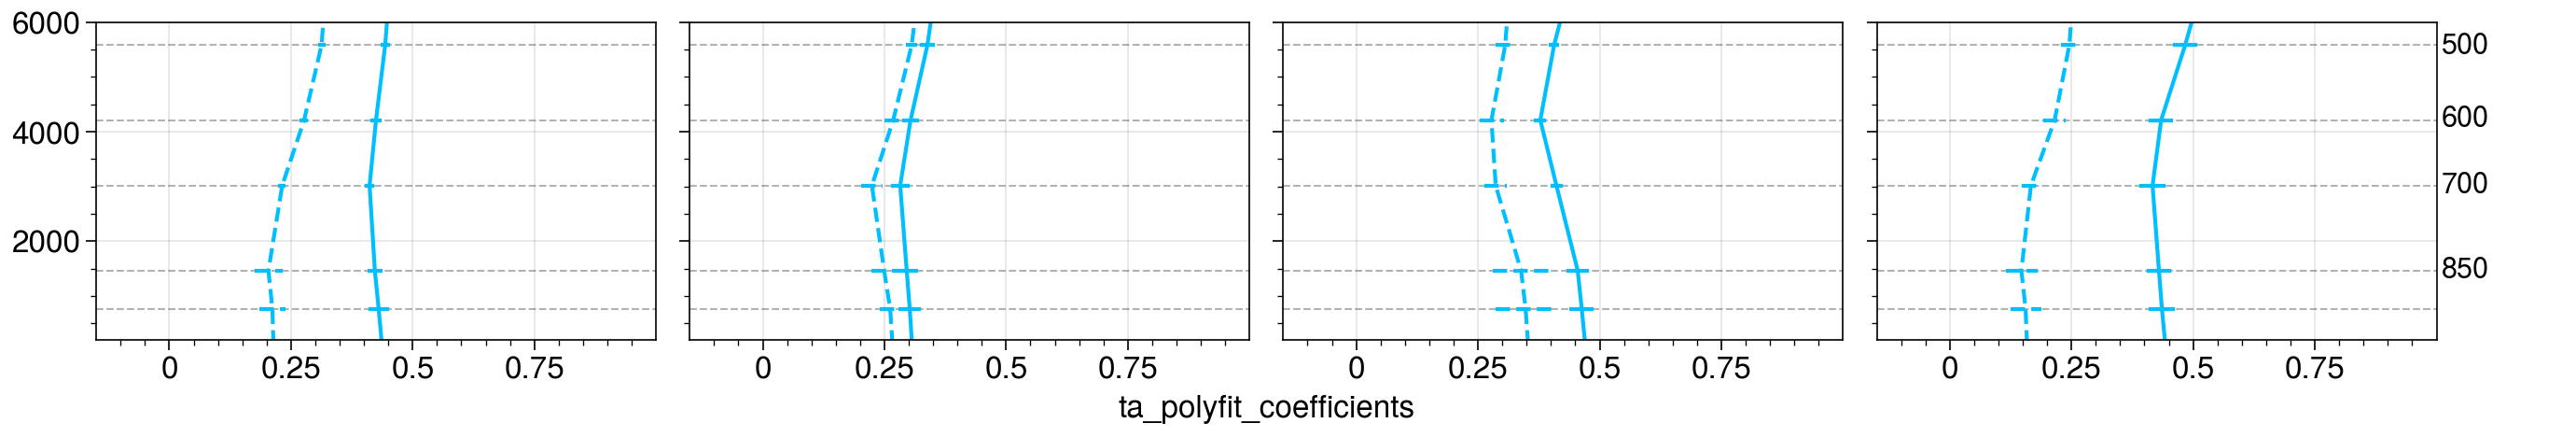

In [56]:
f, axs = pplt.subplots(ncols=4,nrows=1,axheight=1.7,axwidth=3,right=6)

multiplier=10
H_levels_pressure = H_levels_pressure_GCM

for sim in range(1):
    for seas in range(4):
        ax = axs[seas+4*sim]

        for m in range(len(H_levels_pressure)):
            ax.plot([-0.15,1.9],[H_levels_pressure[m],H_levels_pressure[m]],linestyle='--',c='k',linewidth=0.75,alpha=0.3)
        
        ax.plot(multiplier*slopes_ECEarth_hist.isel(season=seas)[:10],H_levels_pressure,c='deepskyblue',linestyle='--')
        ax.plot(multiplier*slopes_ECEarth_fut.isel(season=seas)[:10],H_levels_pressure,c='deepskyblue')
        for lev in range(len(H_levels_pressure)): # spatial standard deviation
            if lev<len(H_levels_pressure):
                var='TTp'
                slope_var = slopes_ECEarth_hist.isel(season=seas)[lev]
                std_var = slopes_ECEarth_hist_std.isel(season=seas)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels_pressure[lev],H_levels_pressure[lev]],c='deepskyblue',
                            linestyle='--')

                slope_var = slopes_ECEarth_fut.isel(season=seas)[lev]
                std_var = slopes_ECEarth_fut_std.isel(season=seas)[lev]
                ax.plot([multiplier*(slope_var-std_var),multiplier*(slope_var+std_var)],[H_levels_pressure[lev],H_levels_pressure[lev]],c='deepskyblue')

        ax.set_xlim(-0.15,1.0)
        ax.set_xticks(np.arange(0.,1.,0.25))
        ax.set_ylim(200,6000)

        if seas==3:
            if len(H_levels_pressure) == 7:
                ax.text(1.01, 650, "925", fontsize=11)
                ax.text(1.01, 1840, "800", fontsize=11)
            ax.text(1.01, 1340, "850", fontsize=11)
            ax.text(1.01, 2880, "700", fontsize=11)
            ax.text(1.01, 4100, "600", fontsize=11)
            ax.text(1.01, 5430, "500", fontsize=11)




/tmp/ipykernel_3334984/791972177.py:4: ProplotWarning: rc setting 'small' was renamed to 'font.smallsize' in version 0.6.
  pplt.rc.update(small=12, large=12)
/tmp/ipykernel_3334984/791972177.py:4: ProplotWarning: rc setting 'large' was renamed to 'font.largesize' in version 0.6.
  pplt.rc.update(small=12, large=12)


sim =  0 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 3 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 sim =  1 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 3 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 sim =  2 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 3 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 sim =  3 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 2 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 3 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 

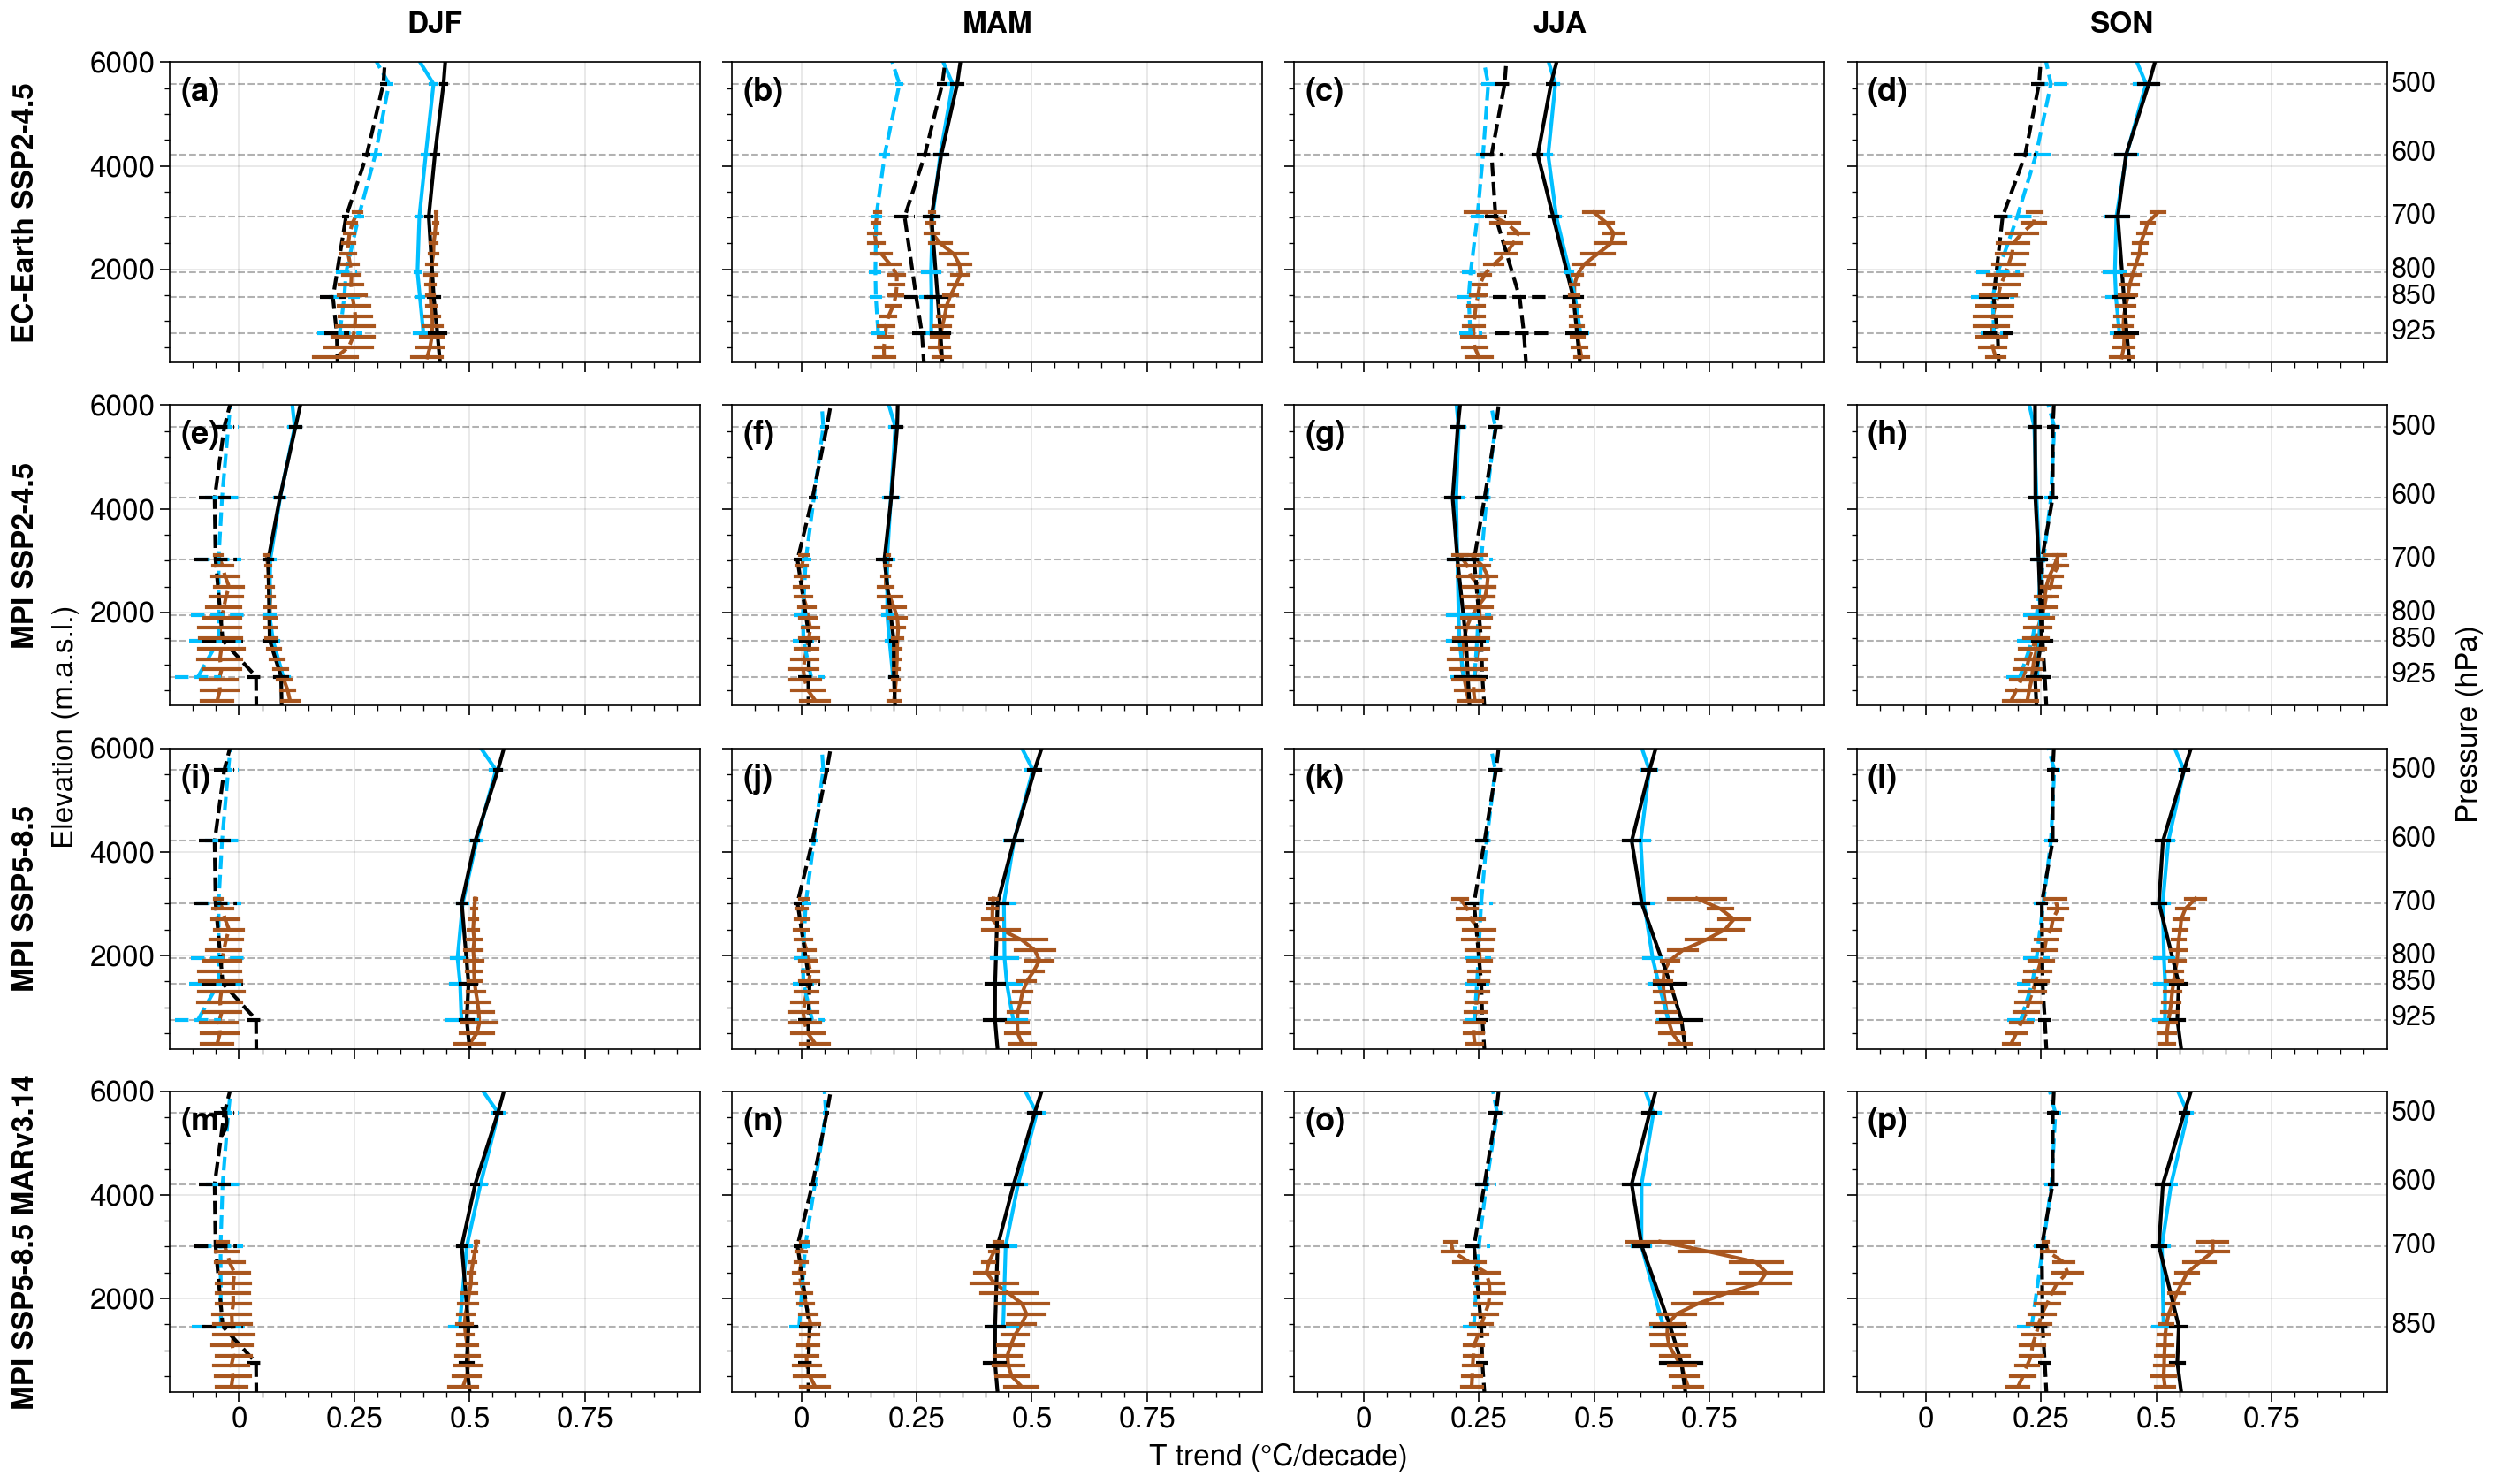

In [57]:
pplt.rc['figure.facecolor'] = 'white'

plot_ground_freeatm_GCM(ds_in_hist1 = ds_ECEarth_hist_TTz_TTp.isel(ztqlev=0), ds_in_fut1 = ds_ECEarth_SSP245_TTz_TTp.isel(ztqlev=0),
                    ds_in_hist2 = ds_MPI_hist_TTz_TTp.isel(ztqlev=0), ds_in_fut2 = ds_MPI_SSP245_TTz_TTp.isel(ztqlev=0),
                    ds_in_hist3 = ds_MPI_hist_TTz_TTp.isel(ztqlev=0), ds_in_fut3 = ds_MPI_SSP585_TTz_TTp.isel(ztqlev=0),
                    ds_in_hist4 = ds314_MPI_hist_TTz_TTp.isel(ztqlev=0), ds_in_fut4 = ds314_MPI_SSP585_TTz_TTp.isel(ztqlev=0),
                    label_on_left=["EC-Earth SSP2-4.5","MPI SSP2-4.5","MPI SSP5-8.5","MPI SSP5-8.5 MARv3.14"],
                       H_levels_pressure = [760,1460,1950,3015,4210,5580,11785])